In [118]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot
from pdpbox import pdp, get_dataset, info_plots
import joblib
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import shap

from sklearn.pipeline import Pipeline
from processing import SetTarget, SetText, SetTextLabels, CustomMapping, LabelEncode, NumEncode, RemoveData
from processing import NAmappingImputer, PandasSimpleImputer, SetDtypes
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import train_test_split
import json

from scipy.stats import skew, norm, probplot


from sklearn.feature_selection import mutual_info_regression
from sklearn.linear_model import Ridge, HuberRegressor, LinearRegression

## Loading data

In [119]:
#find path 
for dirname, _, filenames in os.walk('./data_'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data_/immo_data.csv


In [120]:
#create dataframe 
df = pd.read_csv('./data_/immo_data.csv', lineterminator='\n')
df = df[df['totalRent'].notna()]
df = df[(df.totalRent>60) & (df.totalRent<1000000)]
df['y'] = np.log(np.array(df.totalRent))

In [165]:
df.columns

Index(['regionLevel1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
       'telekomHybridUploadSpeed', 'newlyConst', 'balcony',
       'telekomUploadSpeed', 'totalRent', 'yearConstructed', 'noParkSpaces',
       'firingTypes', 'kitchen', 'cellar', 'houseNumber', 'livingSpace',
       'condition', 'interiorQuality', 'petsAllowed', 'street', 'lift',
       'typeOfFlat', 'postcode', 'noRooms', 'floor', 'numberOfFloors',
       'garden', 'regionLevel2', 'regionLevel3', 'description', 'facilities',
       'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish',
       'electricityBasePrice', 'electricityKwhPrice', 'y'],
      dtype='object')

In [249]:
#df.to_csv('data/main.csv', index=False)

# Log-transformation of skewed target variable


Log-transformation of skewed target variable¶
Log-transformation is a technique used to perform Feature Transformation. It is one of the many techniques that can be used to transform the features so that they are treated equally.

Why do we want models to treat them equally? It is because when we input these features to the model, there is a posibillity that an larger value in an imbalance feature will influence the result more and further affect the model performance. This is not something we will want as each and every row of data are equally important as a predictor.

We wouldn't want the model to prioritize predicting only data with higher sale prices. Hence, scaling and transforming is important for algorithms where distance between the data points is important.

We picked log-transformation here as it has the power to alter the skewness of a distribution towards normality. You can observe how log-transformation of a feature can transform its distribution and scale.

## Distribution plot


 mu = 818.59 and sigma = 1205.35



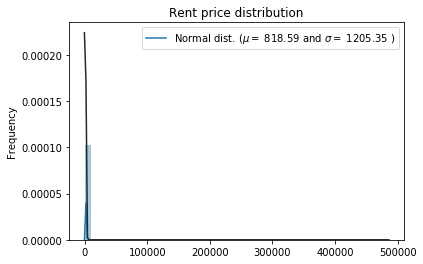

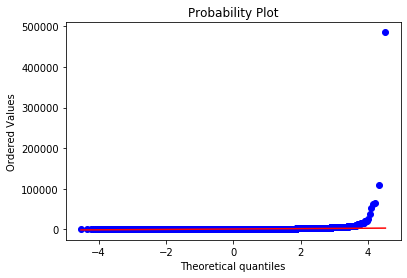

In [121]:
#Log-transformation of skewed target variable

sns.distplot(np.array(df.totalRent) , fit=norm);

(mu, sigma) = norm.fit(np.array(df.totalRent))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Rent price distribution')

# QQ-plot
fig = plt.figure()
res = probplot(np.array(df.totalRent), plot=plt)
plt.show()


 mu = 6.55 and sigma = 0.54



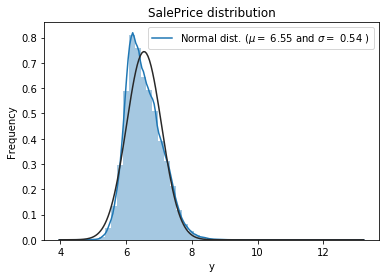

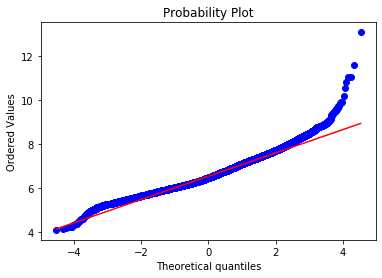

In [122]:
sns.distplot(df.y , fit=norm);
(mu, sigma) = norm.fit(df.y)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = probplot(df.y, plot=plt)

plt.show()

## Check NA 

Index(['serviceCharge', 'heatingType', 'telekomTvOffer',
       'telekomHybridUploadSpeed', 'telekomUploadSpeed', 'yearConstructed',
       'noParkSpaces', 'firingTypes', 'houseNumber', 'condition',
       'interiorQuality', 'petsAllowed', 'street', 'typeOfFlat', 'floor',
       'numberOfFloors', 'description', 'facilities', 'heatingCosts',
       'energyEfficiencyClass', 'lastRefurbish', 'electricityBasePrice',
       'electricityKwhPrice'],
      dtype='object')

None


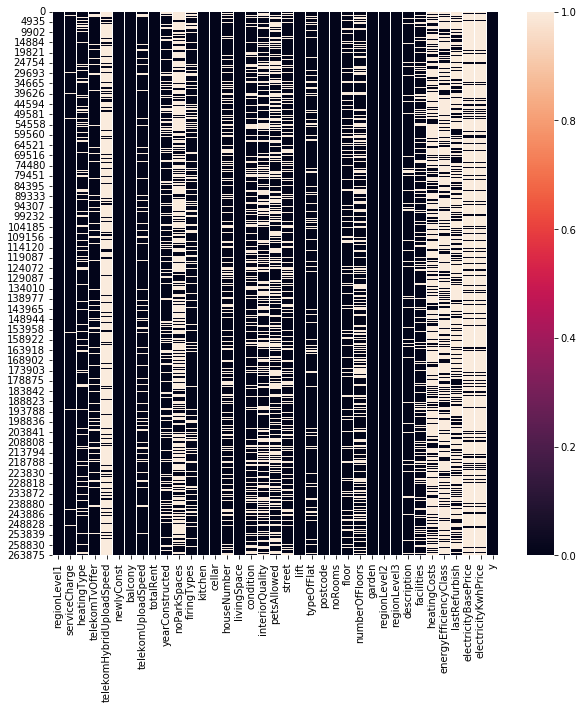

In [123]:
#train
print(display(df.columns[df.isna().any(axis=0)]))
plt.figure(figsize=(10, 10))
sns.heatmap(df.isna())

In [213]:
def analyse_discrete(df, var):
    df = df.copy()
    grs = df.groupby(var)['totalRent'].mean().reset_index()
    plt.figure(figsize=(35,25))
    sns.barplot(x=grs[var], y=grs['totalRent'])
    plt.title(var.upper())
    plt.show()

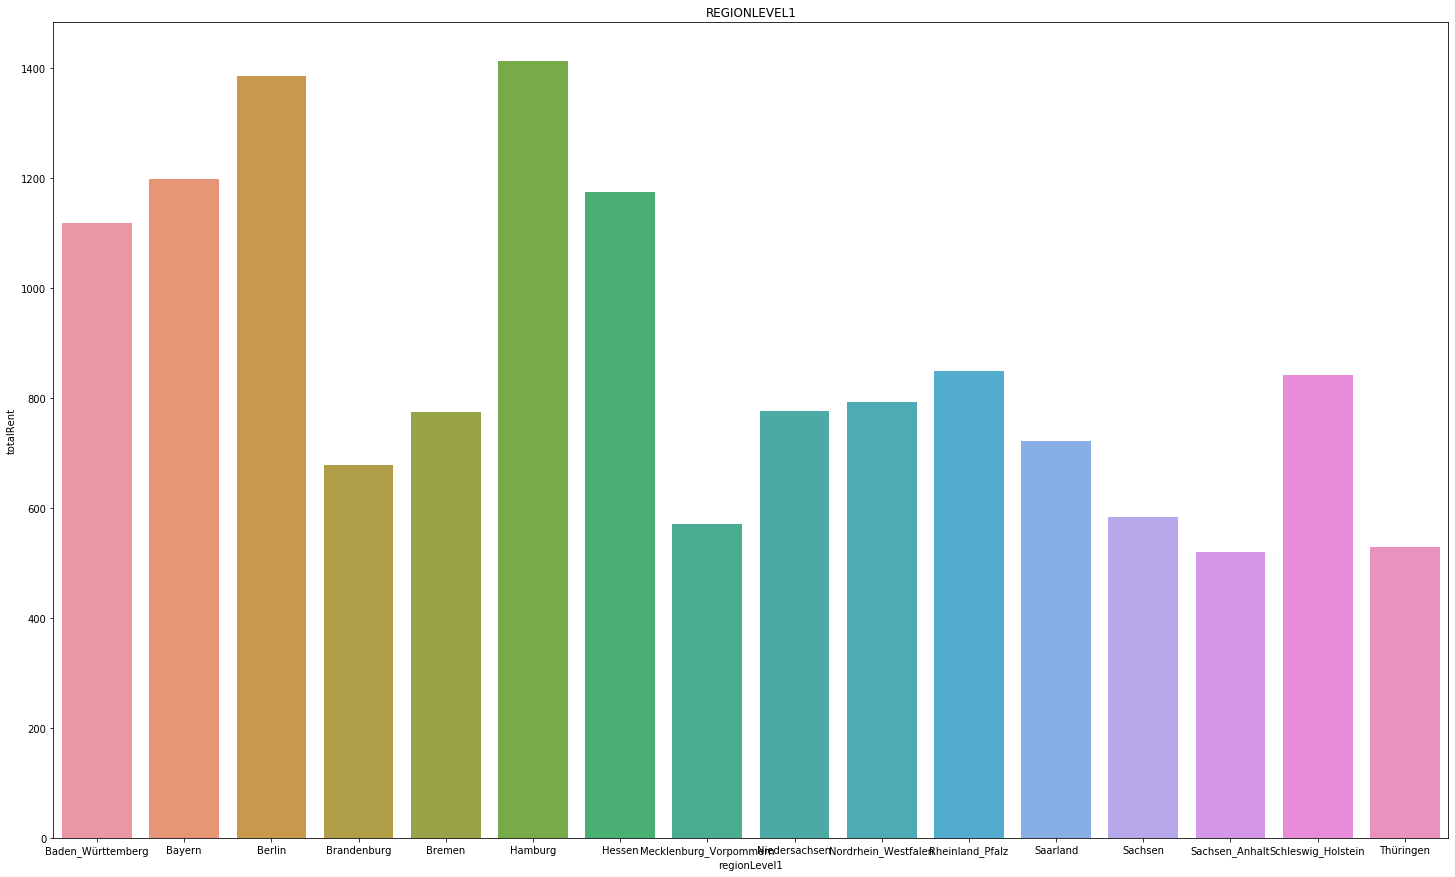

In [206]:
for var in ['regionLevel1']:
    analyse_discrete(df, var)

In [218]:
df[df.regionLevel1 == 'Nordrhein_Westfalen'].groupby('regionLevel2').mean().reset_index()

regionLevel2  serviceCharge  telekomHybridUploadSpeed  \
0                       Aachen     156.130825                      10.0   
1                 Aachen_Kreis     165.470890                      10.0   
2                    Bielefeld     161.144962                      10.0   
3                       Bochum     232.080780                      10.0   
4                         Bonn     203.467032                      10.0   
5                 Borken_Kreis     144.858193                      10.0   
6                      Bottrop     134.248459                      10.0   
7               Coesfeld_Kreis     140.241989                      10.0   
8                     Dortmund     139.007245                      10.0   
9                     Duisburg     145.668799                      10.0   
10                 Düren_Kreis     151.829887                      10.0   
11                  Düsseldorf     204.413058                      10.0   
12           Ennepe_Ruhr_Kreis     137.900786                      10.0   
13                       Essen     151.678336                      10.0   
14            Euskirchen_Kreis     158.494877                      10.0   
15               Gelsenkirchen     114.234552                      10.0   
16             Gütersloh_Kreis     167.271564                      10.0   
17                       Hagen     140.615793                      10.0   
18                        Hamm     123.400588                      10.0   
19             Heinsberg_Kreis     156.713114                      10.0   
20               Herford_Kreis     136.705614                      10.0   
21                       Herne     120.345113                      10.0   
22          Hochsauerlandkreis     140.831205                      10.0   
23                Höxter_Kreis     128.798618                      10.0   
24                 Kleve_Kreis     138.591932                      10.0   
25                     Krefeld     169.393137                      10.0   
26                        Köln     188.383676                      10.0   
27                  Leverkusen     168.989818                      10.0   
28                 Lippe_Kreis     149.658280                      10.0   
29              Mettmann_Kreis     166.820466                      10.0   
30       Minden_Lübbecke_Kreis     167.217516                      10.0   
31            Märkischer_Kreis     148.031734                      10.0   
32             Mönchengladbach     172.669483                      10.0   
33         Mülheim_an_der_Ruhr     169.081342                      10.0   
34                     Münster     188.392120                      10.0   
35           Neuss_Rhein_Kreis     185.688138                      10.0   
36        Oberbergischer_Kreis     162.553935                      10.0   
37                  Oberhausen     140.841921                      10.0   
38                  Olpe_Kreis     153.078125                      10.0   
39             Paderborn_Kreis     126.760459                      10.0   
40        Recklinghausen_Kreis     136.430809                      10.0   
41                   Remscheid     144.633974                      10.0   
42            Rhein_Erft_Kreis     175.098730                      10.0   
43            Rhein_Sieg_Kreis     187.508291                      10.0   
44  Rheinisch_Bergischer_Kreis     202.221127                      10.0   
45   Siegen_Wittgenstein_Kreis     141.651219                      10.0   
46                 Soest_Kreis     150.454211                      10.0   
47                    Solingen     168.582947                      10.0   
48             Steinfurt_Kreis     150.849587                      10.0   
49                  Unna_Kreis     148.286919                      10.0   
50               Viersen_Kreis     163.240306                      10.0   
51             Warendorf_Kreis     151.690140                      10.0   
52                 Wesel_Kreis     168.2226

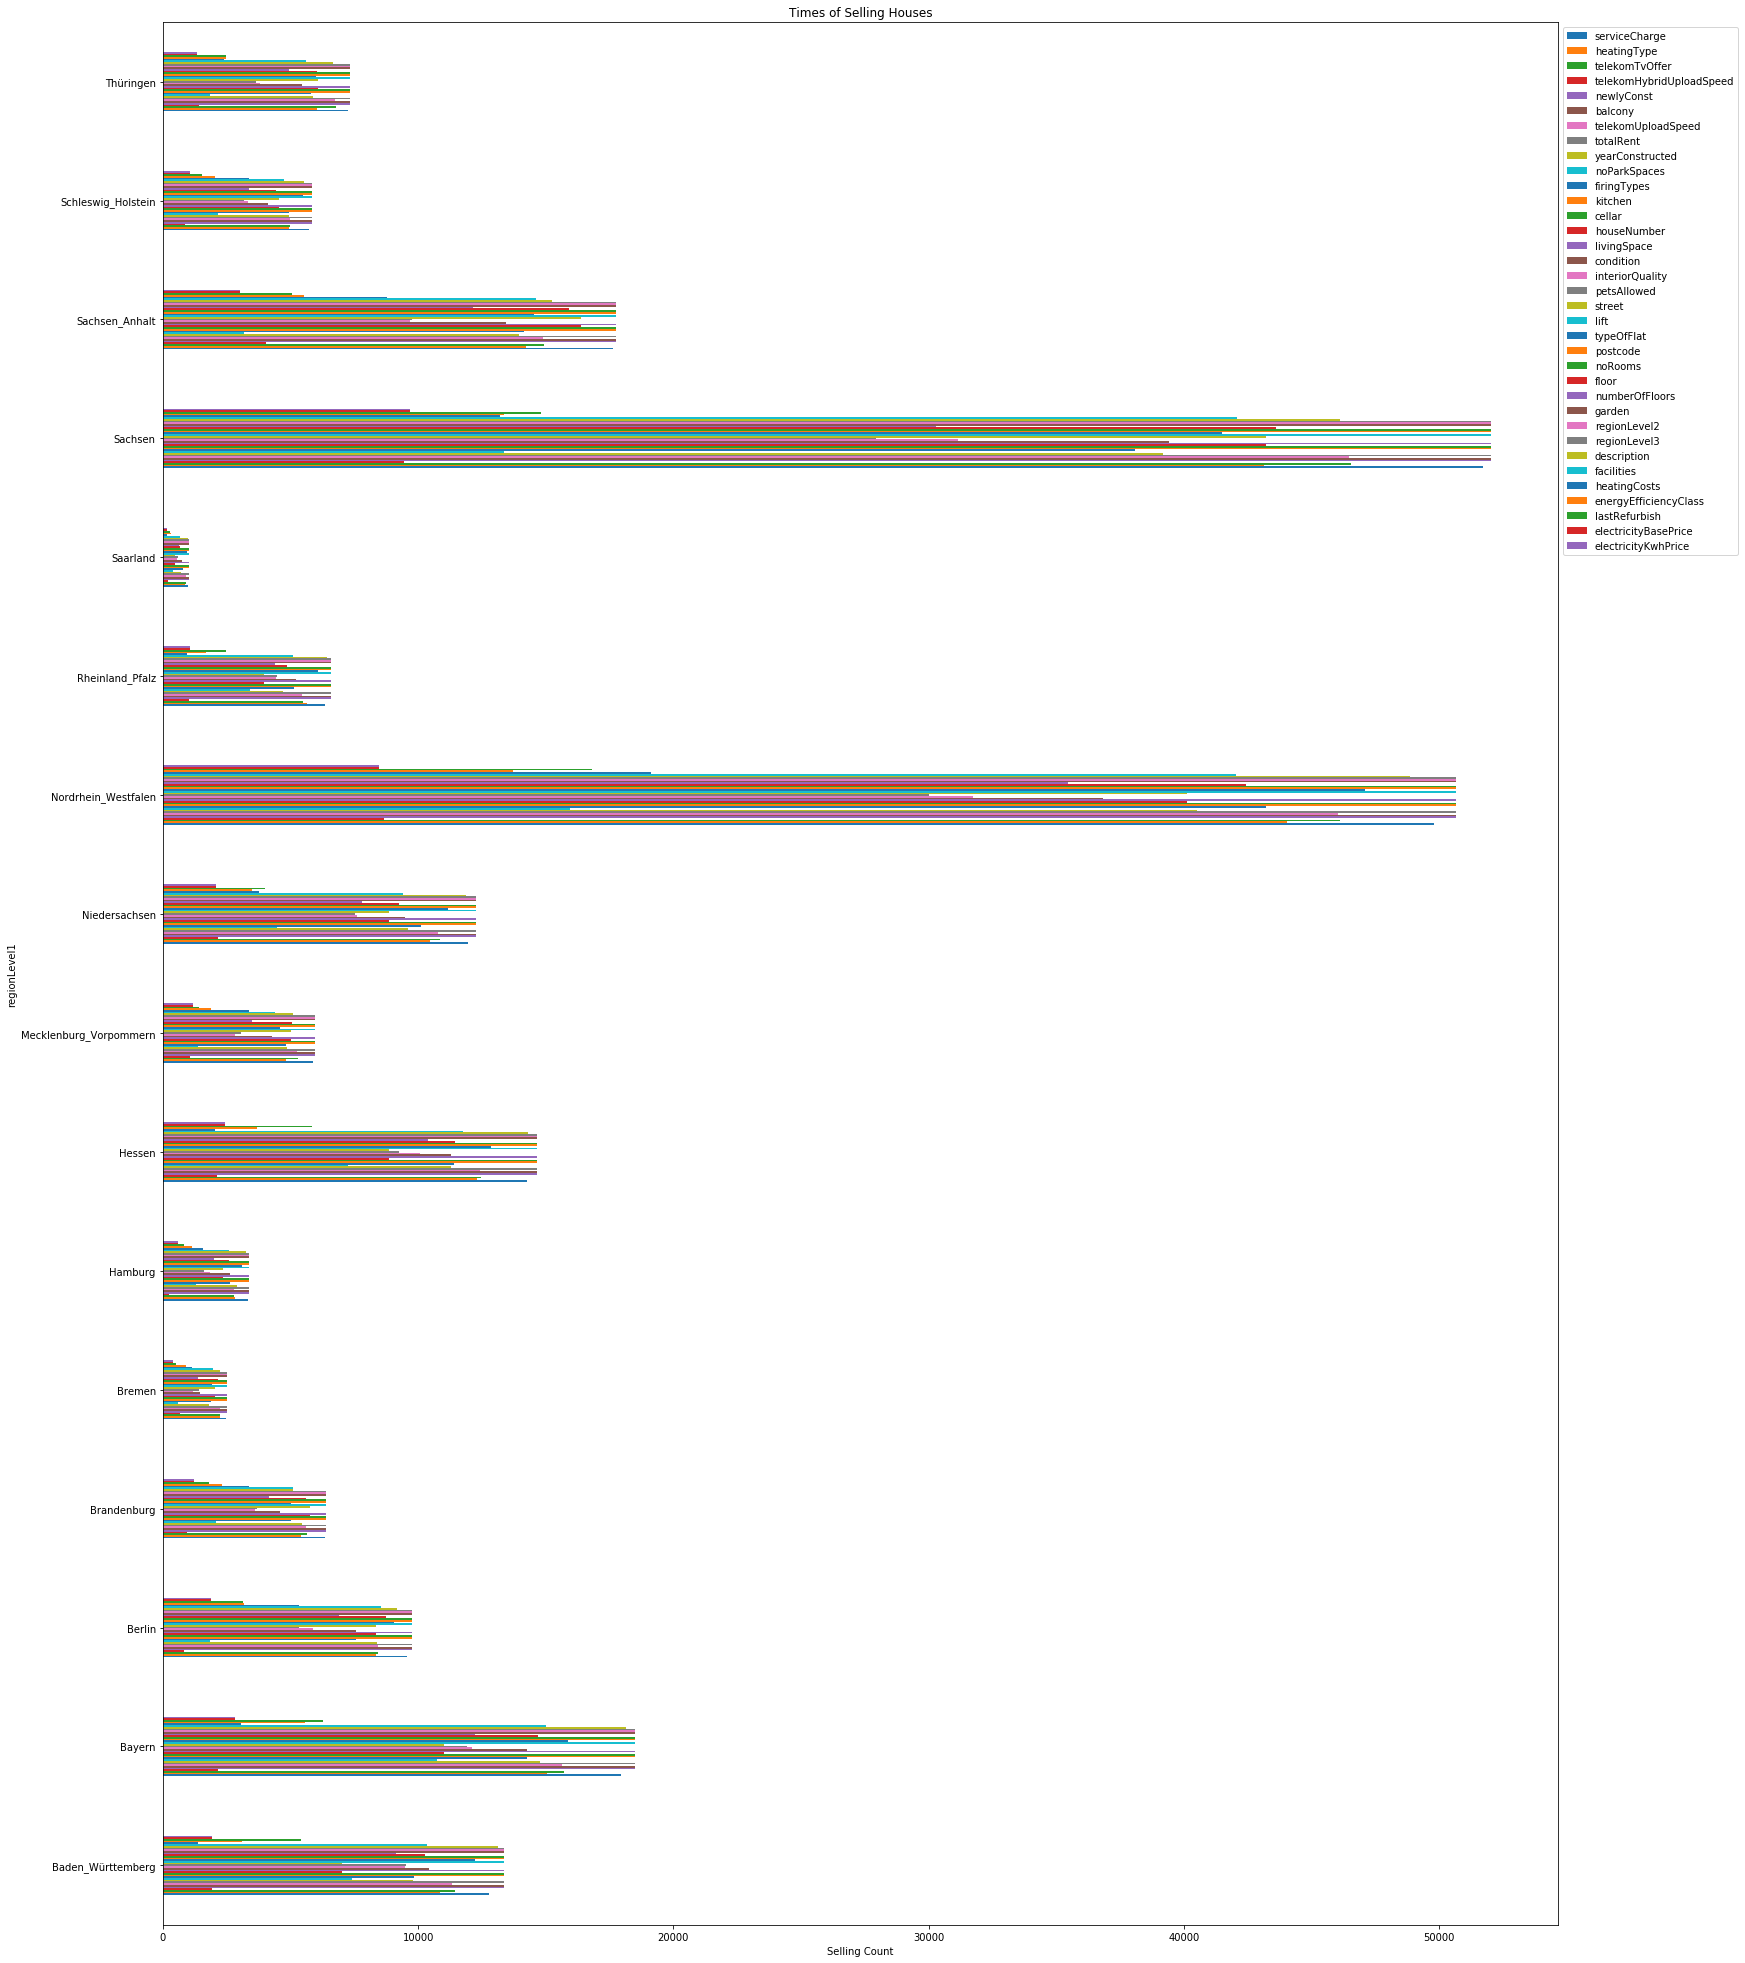

In [187]:
df.groupby(['regionLevel1']).count().plot(kind='barh',figsize=(25,35))
plt.xlabel('Rent Count')
plt.title('Times of Rent)
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

Baden_Württemberg


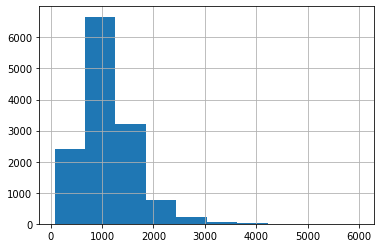

<Figure size 720x720 with 0 Axes>

Thüringen


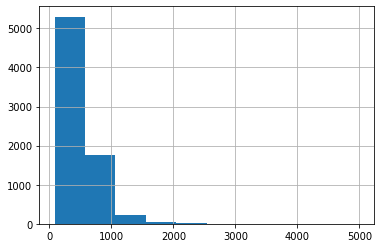

<Figure size 720x720 with 0 Axes>

Hamburg


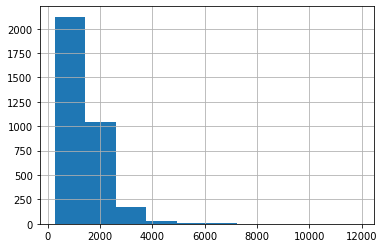

<Figure size 720x720 with 0 Axes>

Brandenburg


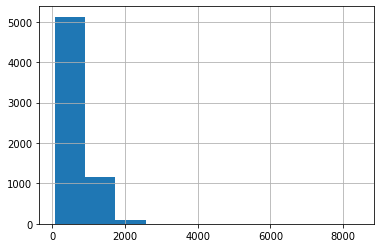

<Figure size 720x720 with 0 Axes>

Sachsen


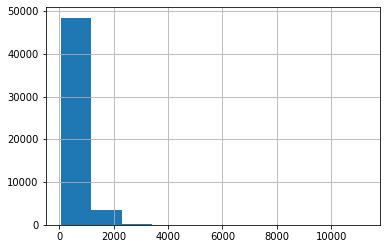

<Figure size 720x720 with 0 Axes>

Rheinland_Pfalz


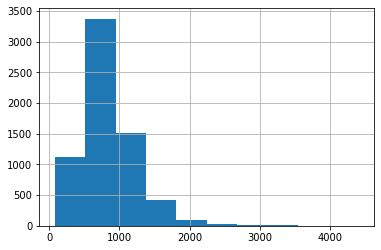

<Figure size 720x720 with 0 Axes>

Hessen


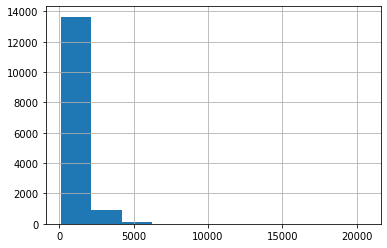

<Figure size 720x720 with 0 Axes>

Berlin


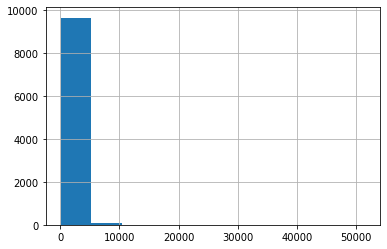

<Figure size 720x720 with 0 Axes>

Saarland


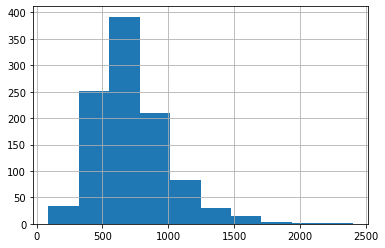

<Figure size 720x720 with 0 Axes>

Sachsen_Anhalt


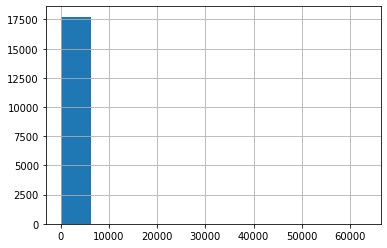

<Figure size 720x720 with 0 Axes>

Schleswig_Holstein


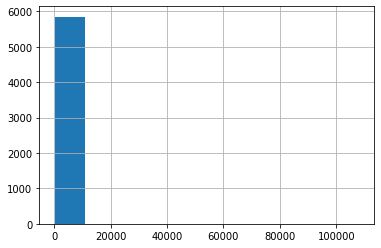

<Figure size 720x720 with 0 Axes>

Bayern


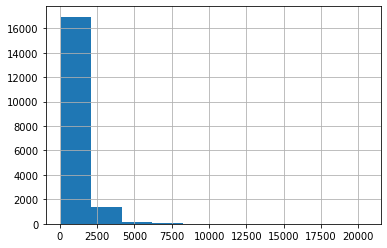

<Figure size 720x720 with 0 Axes>

Niedersachsen


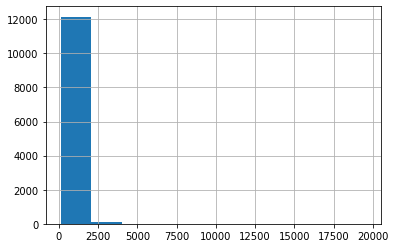

<Figure size 720x720 with 0 Axes>

Bremen


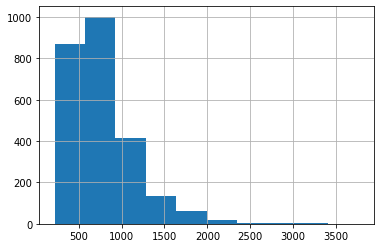

<Figure size 720x720 with 0 Axes>

Mecklenburg_Vorpommern


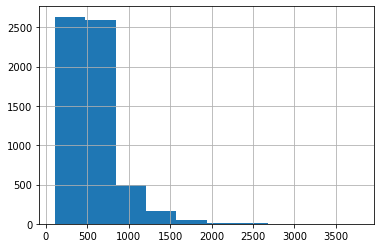

<Figure size 720x720 with 0 Axes>

Nordrhein_Westfalen


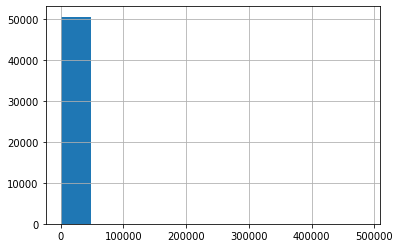

<Figure size 720x720 with 0 Axes>

In [124]:
for col in list(set(list(df['regionLevel1']))):
    print(col)
    df[df['regionLevel1'] == col].totalRent.hist()
    plt.figure(figsize=(10,10))
    plt.show()

Baden_Württemberg


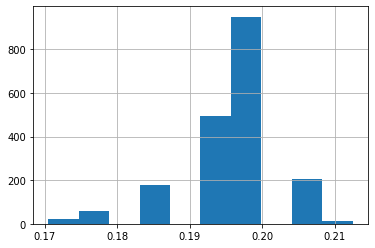

Thüringen


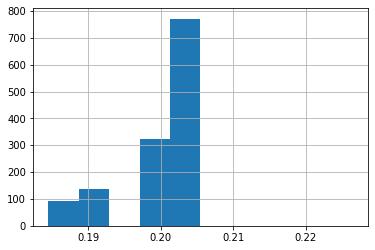

Hamburg


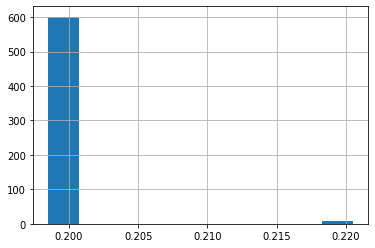

Brandenburg


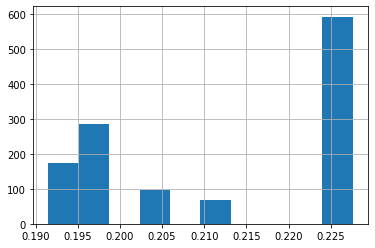

Sachsen


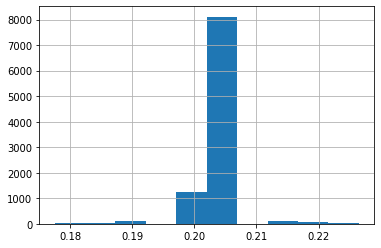

Rheinland_Pfalz


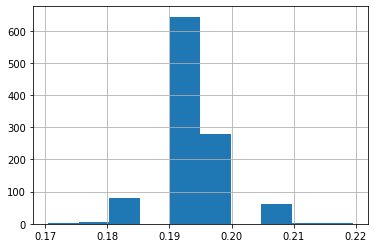

Hessen


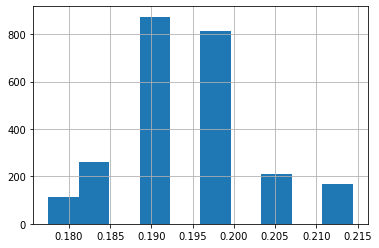

Berlin


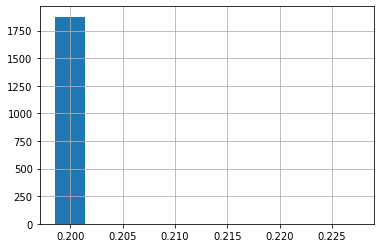

Saarland


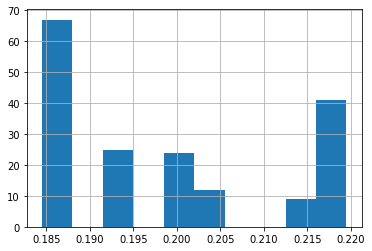

Sachsen_Anhalt


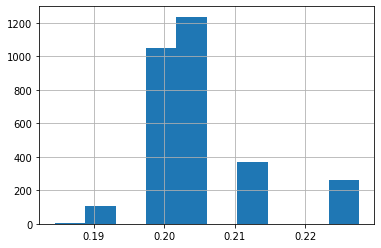

Schleswig_Holstein


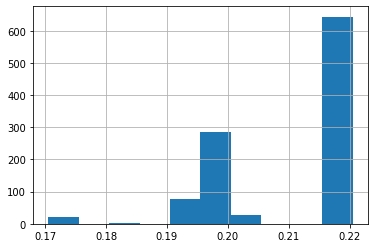

Bayern


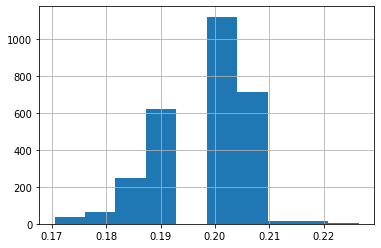

Niedersachsen


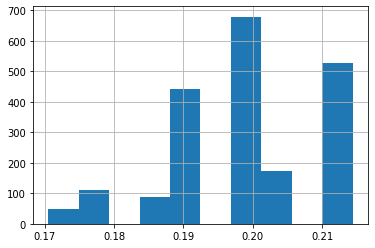

Bremen


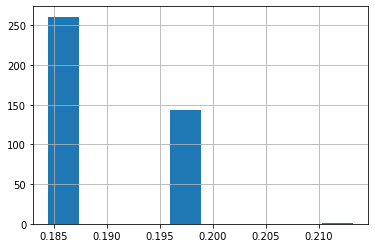

Mecklenburg_Vorpommern


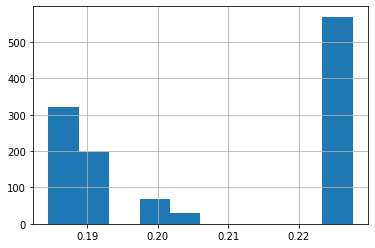

Nordrhein_Westfalen


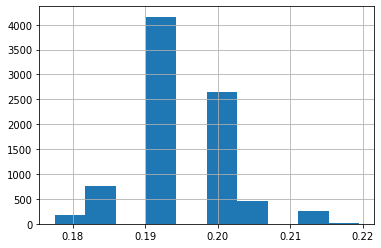

In [125]:
for col in list(set(list(df['regionLevel1']))):
    print(col)
    df[df['regionLevel1'] == col].electricityKwhPrice.hist()
    plt.show()    

## Analysis numeric data 

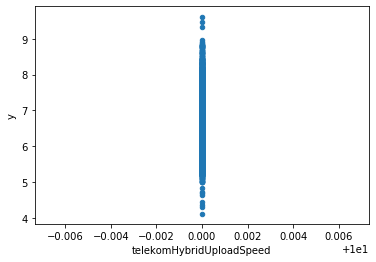

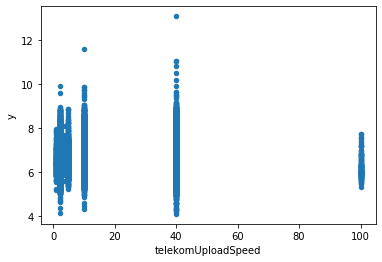

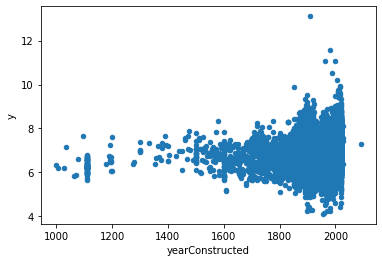

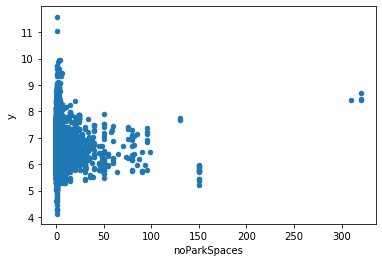

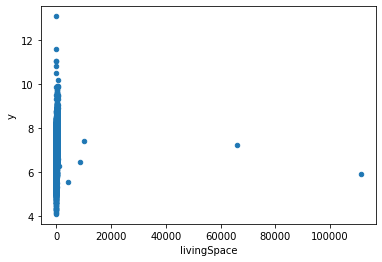

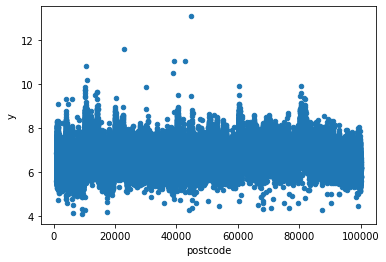

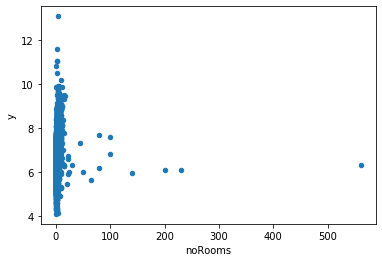

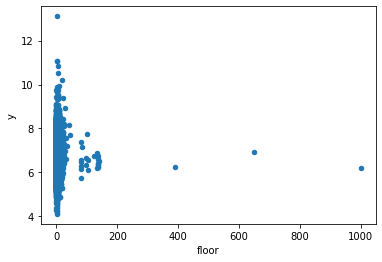

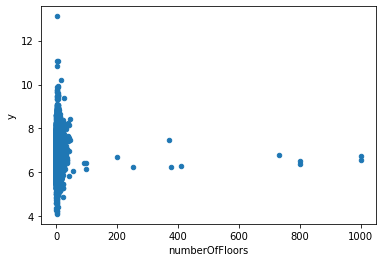

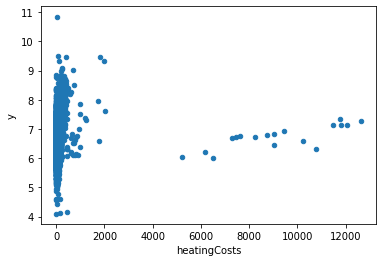

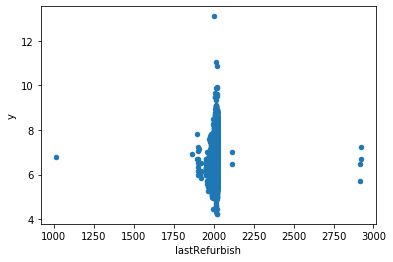

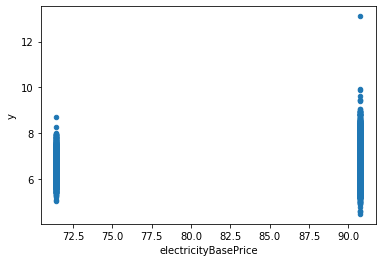

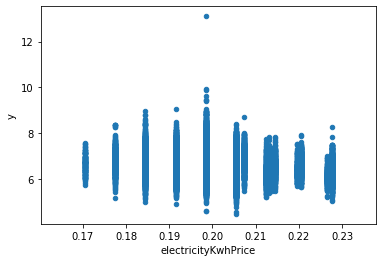

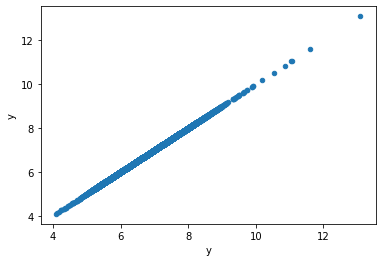

In [14]:
# num_data
col = ['kitchen','newlyConst', 'balcony','cellar', 'lift', 'garden']
for col in col:
    df[col] = df[col].astype('str')
    
numeric_data_train = df.loc[:, df.dtypes != 'object'].drop(['totalRent'], axis=1)
for X in numeric_data_train.columns[1:]:
    
    numeric_data_train.plot(kind='scatter', x=X, y='y')

## Analysis categorical data

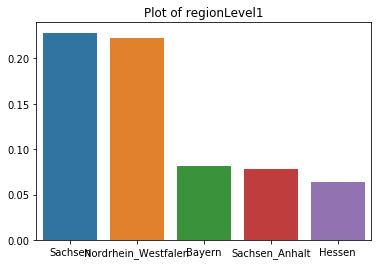

<Figure size 1440x2880 with 0 Axes>

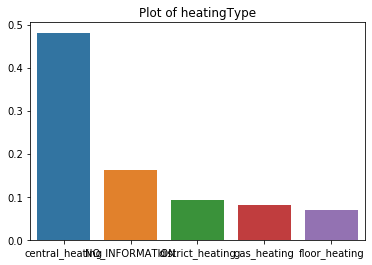

<Figure size 1440x2880 with 0 Axes>

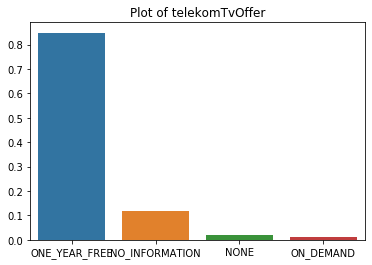

<Figure size 1440x2880 with 0 Axes>

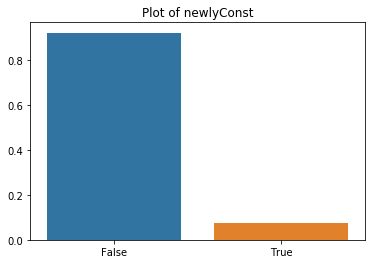

<Figure size 1440x2880 with 0 Axes>

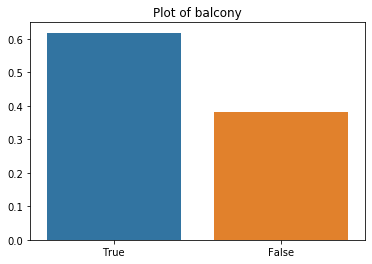

<Figure size 1440x2880 with 0 Axes>

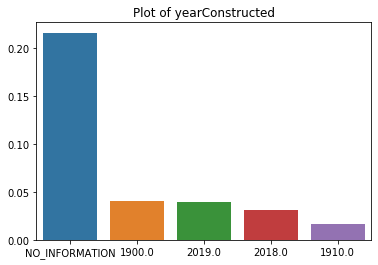

<Figure size 1440x2880 with 0 Axes>

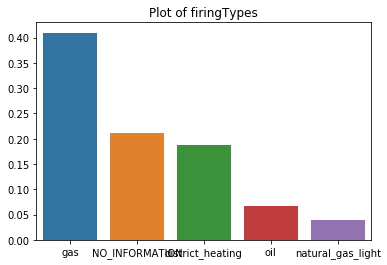

<Figure size 1440x2880 with 0 Axes>

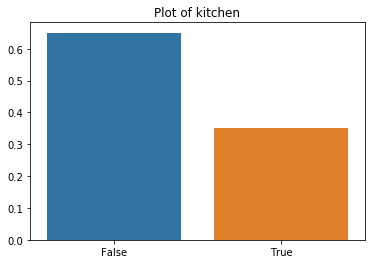

<Figure size 1440x2880 with 0 Axes>

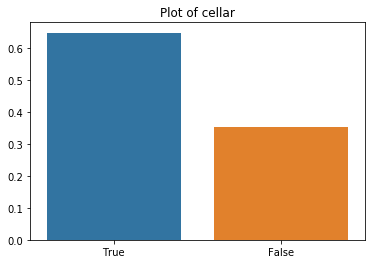

<Figure size 1440x2880 with 0 Axes>

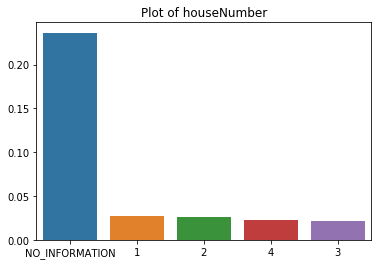

<Figure size 1440x2880 with 0 Axes>

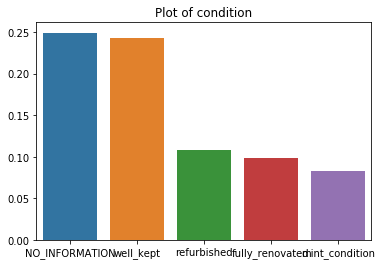

<Figure size 1440x2880 with 0 Axes>

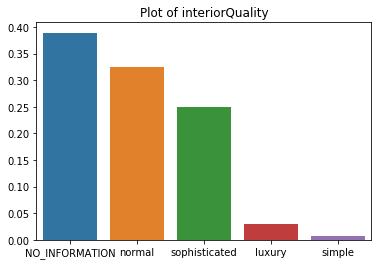

<Figure size 1440x2880 with 0 Axes>

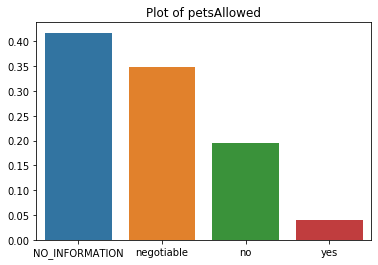

<Figure size 1440x2880 with 0 Axes>

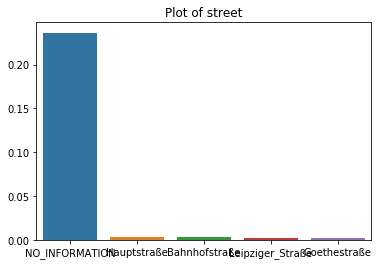

<Figure size 1440x2880 with 0 Axes>

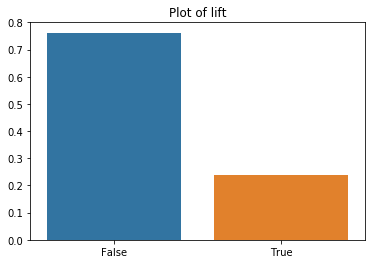

<Figure size 1440x2880 with 0 Axes>

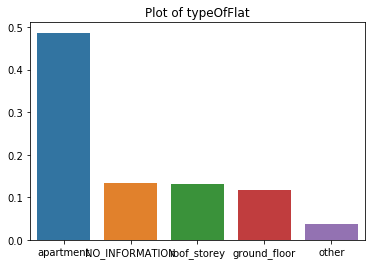

<Figure size 1440x2880 with 0 Axes>

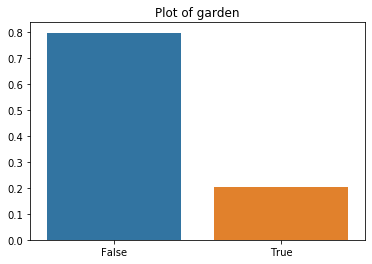

<Figure size 1440x2880 with 0 Axes>

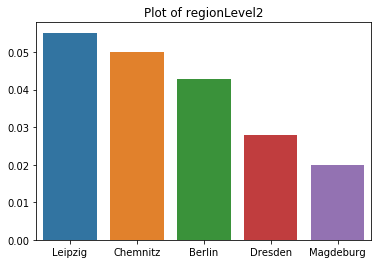

<Figure size 1440x2880 with 0 Axes>

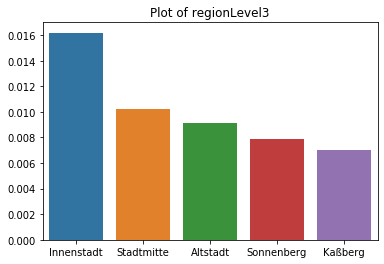

<Figure size 1440x2880 with 0 Axes>

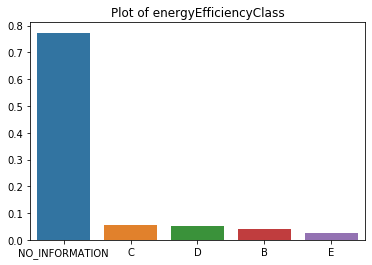

<Figure size 1440x2880 with 0 Axes>

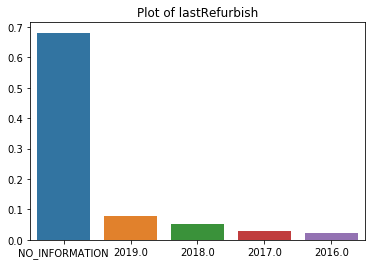

<Figure size 1440x2880 with 0 Axes>

In [65]:
#cat
cat_train = df.loc[:, df.dtypes == 'object'].drop(['description', 'facilities'], axis=1)
# analysis cat 
for metrics in list(cat_train.columns):
    table = df[metrics].value_counts(normalize=True).head()
    sns.barplot(x=table.index,y=table.values)
    plt.title("Plot of "+ metrics)
    plt.figure(figsize=(20, 40))
    plt.show()
    print("\n")

## Create json features

It needs for data processing pipeline and should use for train and prediction!

In [50]:
json_features = {
    'na_map': {
        'telekomHybridUploadSpeed':0,
        'telekomUploadSpeed':0,
        'noParkSpaces':-1,
        'floor':-111,
        'numberOfFloors':-111,
        'heatingCosts':-111,
        'heatingType':'NO_INFORMATION',
        'telekomTvOffer':'NO_INFORMATION',
        'yearConstructed':'NO_INFORMATION',
        'firingTypes':'NO_INFORMATION',
        'houseNumber':'NO_INFORMATION',
        'condition':'NO_INFORMATION',
        'interiorQuality':'NO_INFORMATION',
        'petsAllowed':'NO_INFORMATION',
        'street':'NO_INFORMATION',
        'typeOfFlat':'NO_INFORMATION',
        'description':'NO_INFORMATION',
        'facilities':'NO_INFORMATION',
        'energyEfficiencyClass':'NO_INFORMATION',
        'lastRefurbish':'NO_INFORMATION'},            
    'preprocessing':{
                    'str':['regionLevel1', 'heatingType', 'telekomTvOffer', 'newlyConst',
                           'balcony', 'firingTypes', 'kitchen', 'cellar', 'houseNumber',
                           'condition', 'interiorQuality', 'petsAllowed', 'street', 'lift',
                           'typeOfFlat', 'garden', 'regionLevel2', 'regionLevel3', 'description',
                           'facilities', 'energyEfficiencyClass','telekomHybridUploadSpeed',
                           'telekomUploadSpeed','yearConstructed','noParkSpaces','livingSpace',
                           'floor','postcode','numberOfFloors','lastRefurbish'],
                    'int':[],
                    'float':['serviceCharge', 'noRooms',
                             'heatingCosts', 'electricityBasePrice','electricityKwhPrice']},
    'features': {'cat':['regionLevel1', 'heatingType', 'telekomTvOffer', 'newlyConst',
                        'balcony', 'firingTypes', 'kitchen', 'cellar', 'houseNumber',
                        'condition', 'interiorQuality', 'petsAllowed', 'street', 'lift',
                        'typeOfFlat', 'garden', 'regionLevel2', 'regionLevel3', 'description',
                        'facilities', 'energyEfficiencyClass',
                        'telekomHybridUploadSpeed','telekomUploadSpeed',
                        'yearConstructed','noParkSpaces','livingSpace',
                        'floor','postcode','numberOfFloors','lastRefurbish'],
                 'num': ['serviceCharge', 'noRooms',
                         'heatingCosts', 'electricityBasePrice','electricityKwhPrice'],
                 'drop_col':['regionLevel1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
                             'telekomHybridUploadSpeed', 'newlyConst', 'balcony',
                             'telekomUploadSpeed', 'yearConstructed', 'noParkSpaces', 'firingTypes',
                             'kitchen', 'cellar', 'houseNumber', 'livingSpace', 'condition',
                             'interiorQuality', 'petsAllowed', 'street', 'lift', 'typeOfFlat',
                             'postcode', 'noRooms', 'floor', 'numberOfFloors', 'garden',
                             'regionLevel2', 'regionLevel3', 'description', 'facilities',
                             'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish',
                             'electricityBasePrice', 'electricityKwhPrice',
                             'description_transform', 'facilities_transform']
                }
}

# save json
json_string = json.dumps(json_features)
with open('json_data_.json', 'w') as outfile:
    outfile.write(json_string)

In [436]:
json_features2 = {
    'na_map': {
        'telekomHybridUploadSpeed':0,
        'telekomUploadSpeed':0,
        'noParkSpaces':-1,
        'floor':-111,
        'numberOfFloors':-111,
        'heatingCosts':-111,
        'heatingType':'NO_INFORMATION',
        'telekomTvOffer':'NO_INFORMATION',
        'yearConstructed':'NO_INFORMATION',
        'firingTypes':'NO_INFORMATION',
        'houseNumber':'NO_INFORMATION',
        'condition':'NO_INFORMATION',
        'interiorQuality':'NO_INFORMATION',
        'petsAllowed':'NO_INFORMATION',
        'street':'NO_INFORMATION',
        'typeOfFlat':'NO_INFORMATION',
        'description':'NO_INFORMATION',
        'facilities':'NO_INFORMATION',
        'energyEfficiencyClass':'NO_INFORMATION',
        'lastRefurbish':'NO_INFORMATION'},            
    'preprocessing':{
                    'str':['regionLevel1', 'heatingType', 'telekomTvOffer', 'newlyConst',
                           'balcony', 'firingTypes', 'kitchen', 'cellar', 'houseNumber',
                           'condition', 'interiorQuality', 'petsAllowed', 'street', 'lift',
                           'typeOfFlat', 'garden', 'regionLevel2', 'regionLevel3', 'description',
                           'facilities', 'energyEfficiencyClass','telekomHybridUploadSpeed',
                           'yearConstructed','postcode','lastRefurbish'],
                    'int':[],
                    'float':['serviceCharge', 'noRooms',
                             'heatingCosts', 'electricityBasePrice','electricityKwhPrice',
                             'telekomUploadSpeed','noParkSpaces','livingSpace','floor', 'numberOfFloors']},
    'features': {'cat':['regionLevel1', 'heatingType', 'telekomTvOffer',
                        'firingTypes', 'houseNumber','condition',
                        'interiorQuality', 'petsAllowed', 'street',
                        'typeOfFlat', 'regionLevel2',
                        'regionLevel3','energyEfficiencyClass','telekomHybridUploadSpeed',
                        'yearConstructed','postcode','lastRefurbish'],
                 'bool':['kitchen','newlyConst', 'balcony', 'cellar', 'lift', 'garden'],
                 'num': ['serviceCharge', 'noRooms','heatingCosts', 'livingSpace',
                         'electricityBasePrice','electricityKwhPrice','telekomUploadSpeed','noParkSpaces',
                         'floor','numberOfFloors'],
                 'text': ['description', 'facilities'],
                 'drop_col':['regionLevel1', 'serviceCharge', 'heatingType', 'telekomTvOffer',
                             'telekomHybridUploadSpeed', 'newlyConst', 'balcony',
                             'telekomUploadSpeed', 'yearConstructed', 'noParkSpaces', 'firingTypes',
                             'kitchen', 'cellar', 'houseNumber', 'livingSpace', 'condition',
                             'interiorQuality', 'petsAllowed', 'street', 'lift', 'typeOfFlat',
                             'postcode', 'noRooms', 'floor', 'numberOfFloors', 'garden',
                             'regionLevel2', 'regionLevel3', 'description', 'facilities',
                             'heatingCosts', 'energyEfficiencyClass', 'lastRefurbish',
                             'electricityBasePrice', 'electricityKwhPrice',
                             'description_transform', 'facilities_transform']
                }
}

# save json
json_string = json.dumps(json_features2)
with open('json_data_5.json', 'w') as outfile:
    outfile.write(json_string)

# SNAP 
## Features importance

In [290]:
# set target
df = pd.read_csv('data/train.csv', lineterminator='\n')
pipeline_target = Pipeline(steps=[
    ('set_target', SetTarget(['totalRent'], 'log')),
    ("remove_data", RemoveData(['totalRent']))])
DF = pipeline_target.transform(df)

In [291]:
#split data
train_, test_ = train_test_split(DF, test_size=0.10, random_state=42)
train_, test_ = train_.reset_index(), test_.reset_index()
train_, test_ = train_.drop(columns='index'), test_.drop(columns='index')


# prepare data 
Y_train, Y_valid = train_[['y']], test_[['y']]
train_, test_ = train_.drop(columns='y'), test_.drop(columns='y')

# load Pipeline
pipeline = joblib.load('saved_models/Pipeline/pipeline_json_data_4.json_2022-04-12 17:32:13.pkl')
# transform data
X_train = pipeline.transform(train_)
X_valid = pipeline.transform(test_)

# prediction
xgb_model = XGBRegressor()
xgb_model.load_model("saved_models/XGB/XGBRegressor_json_data_4.json_2022-04-12 21:35:03.json")

In [231]:
# get expaliner
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train)

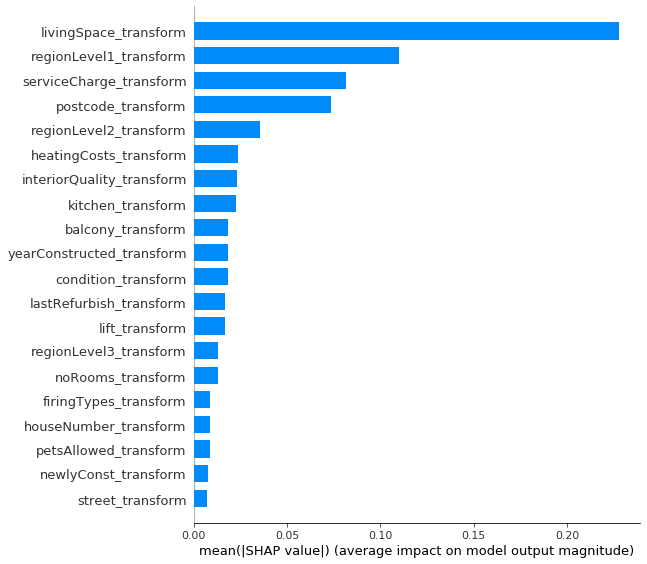

In [232]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

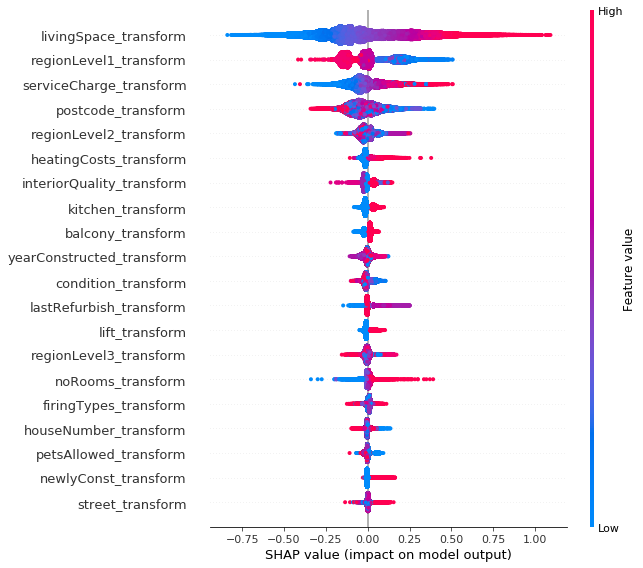

In [233]:
shap.summary_plot(shap_values, X_train)

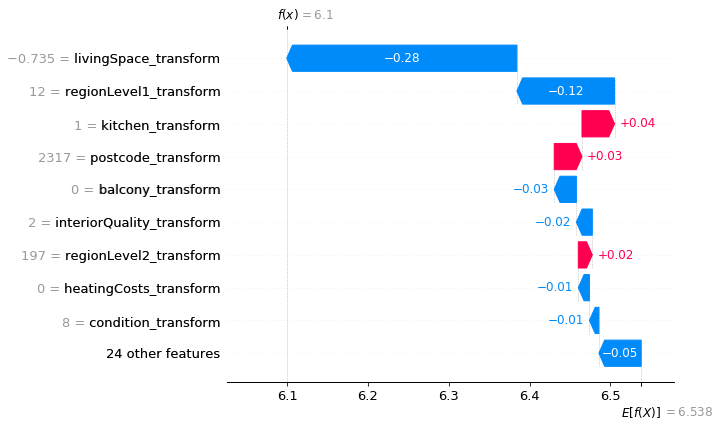

In [235]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

# Binary feature analysis
## Target distribution through feature

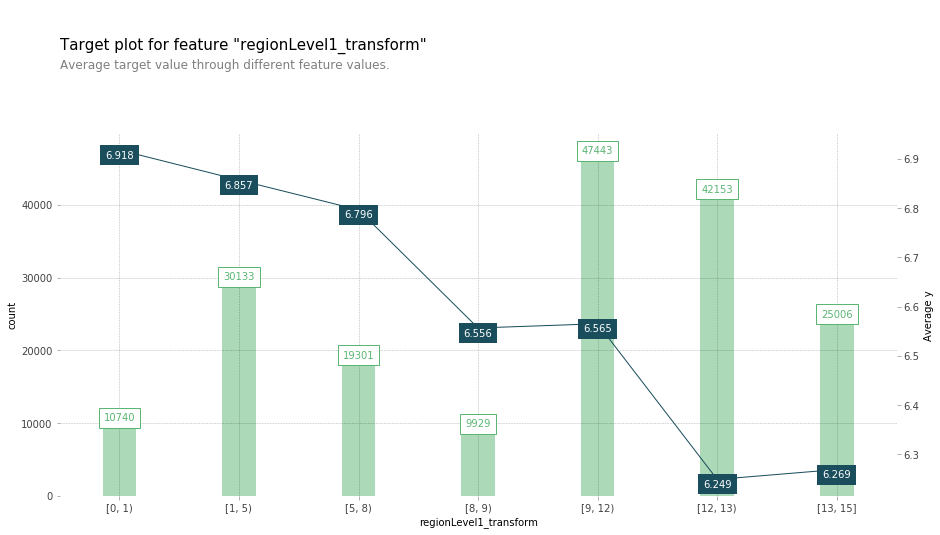

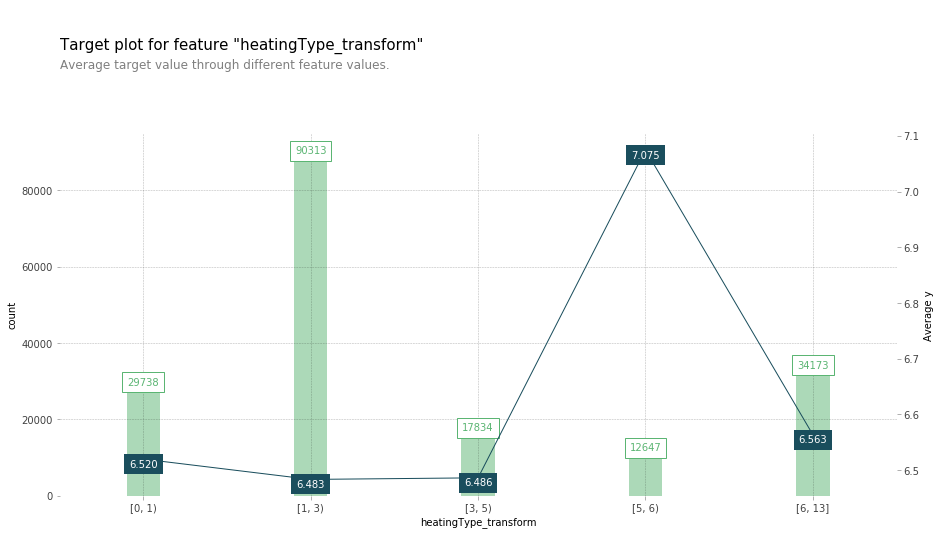

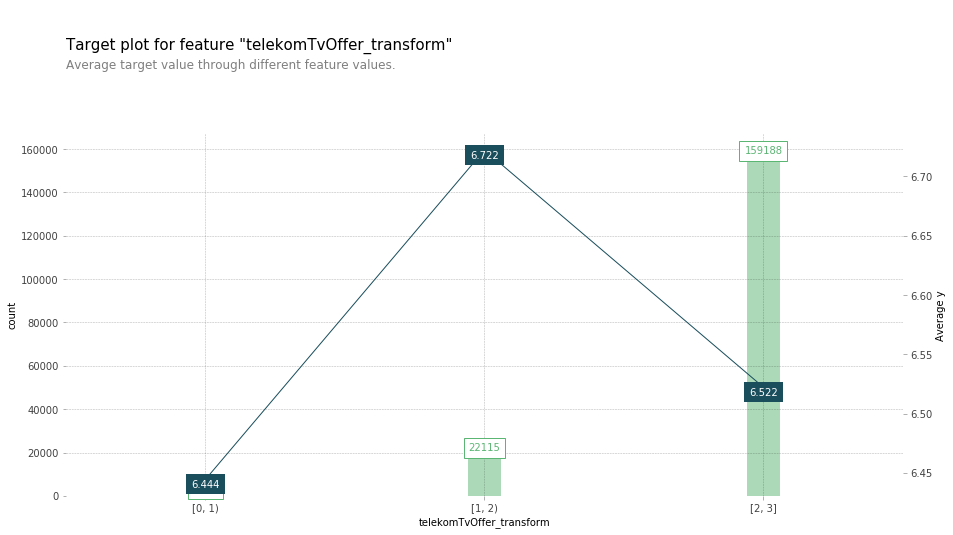

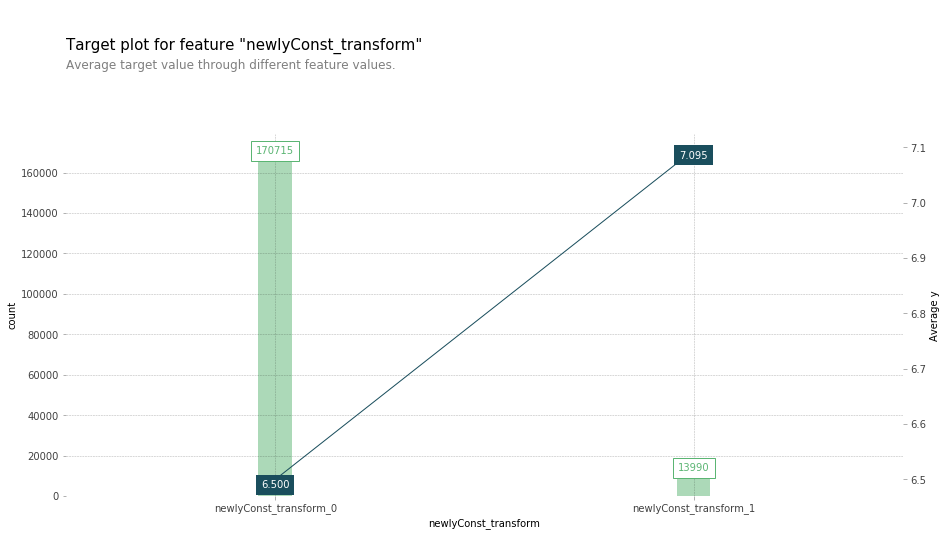

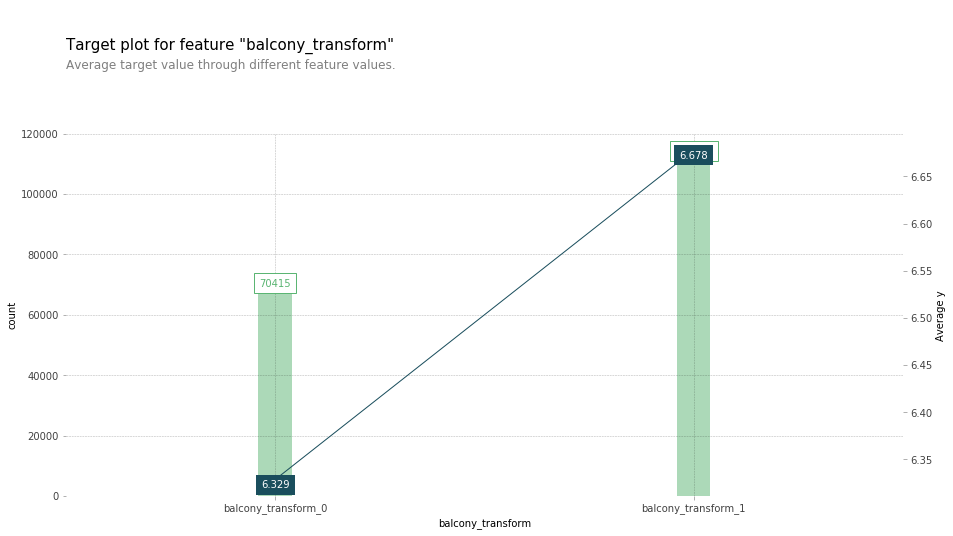

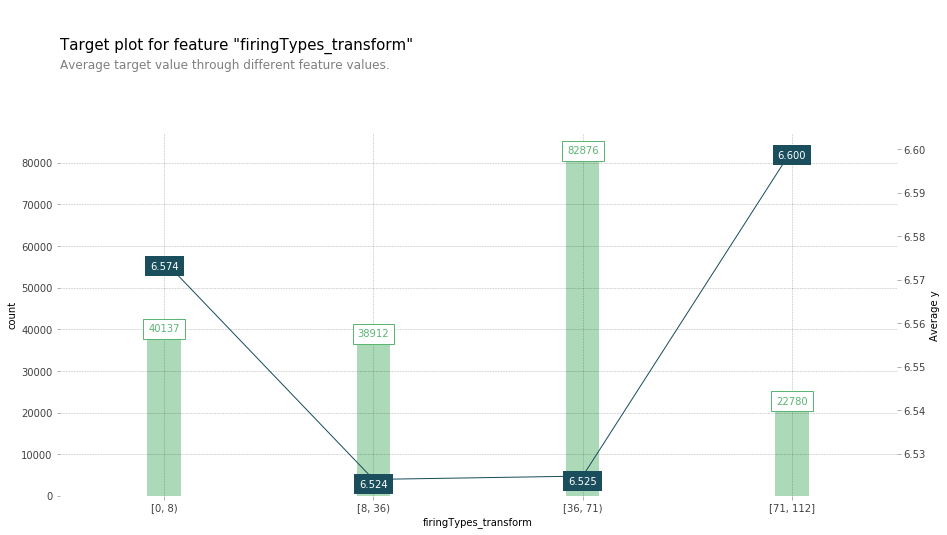

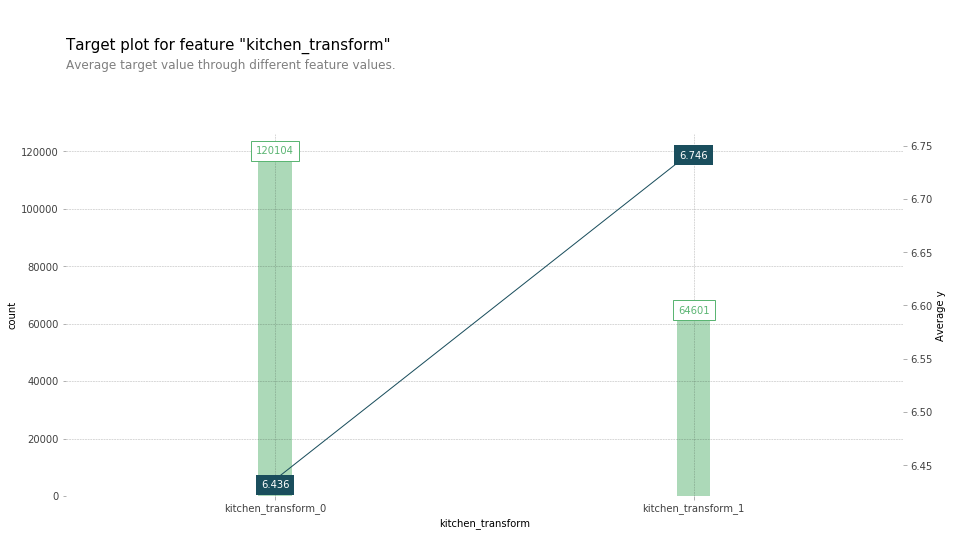

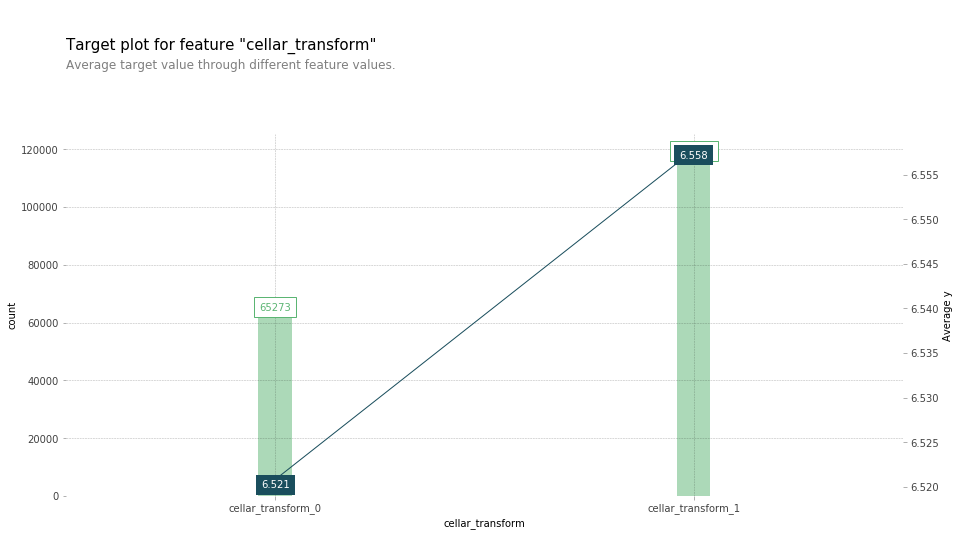

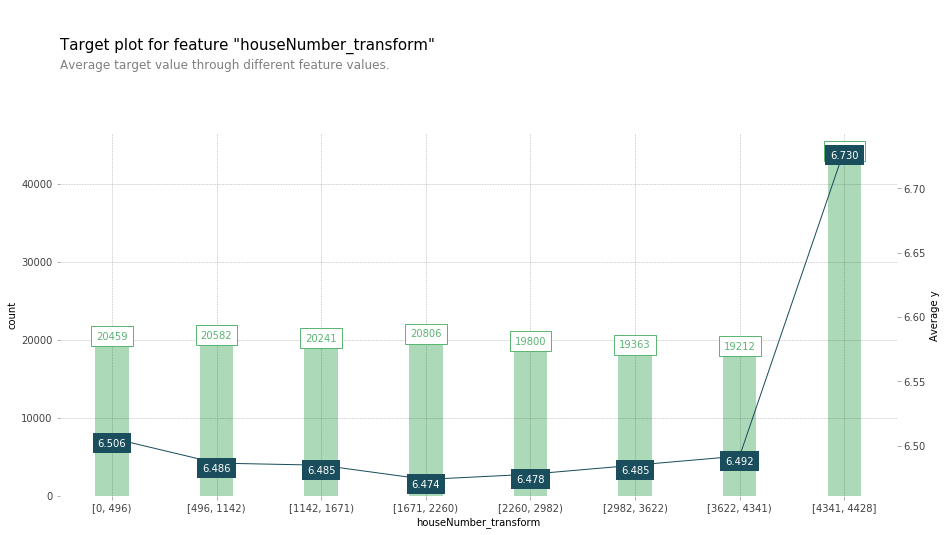

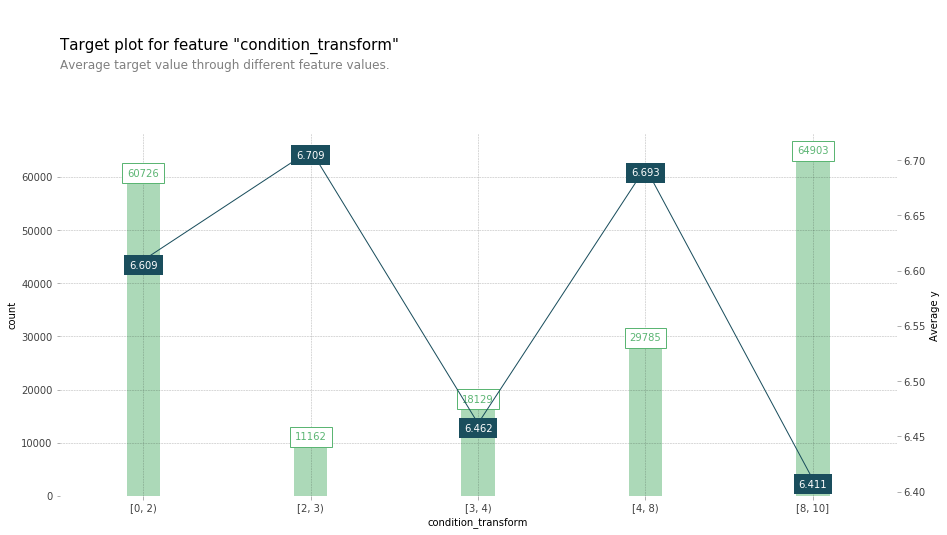

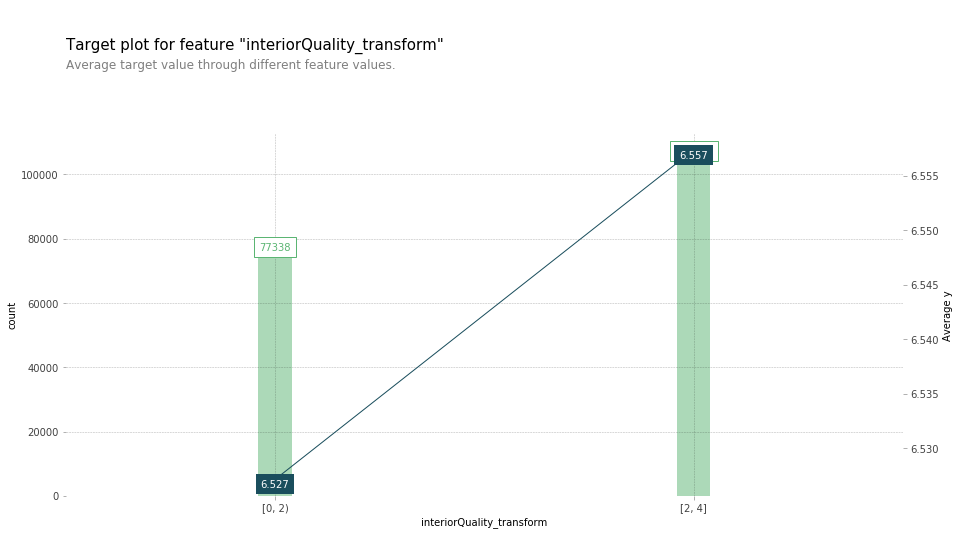

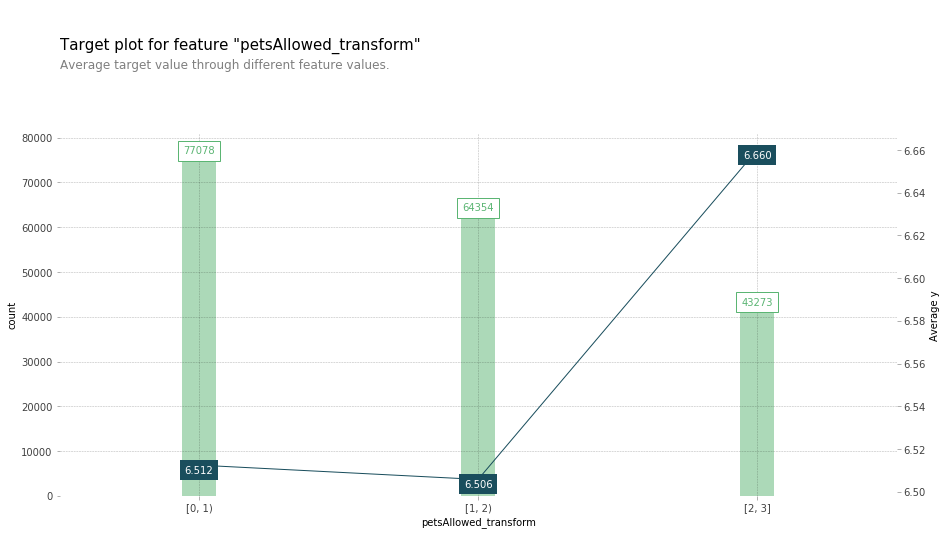

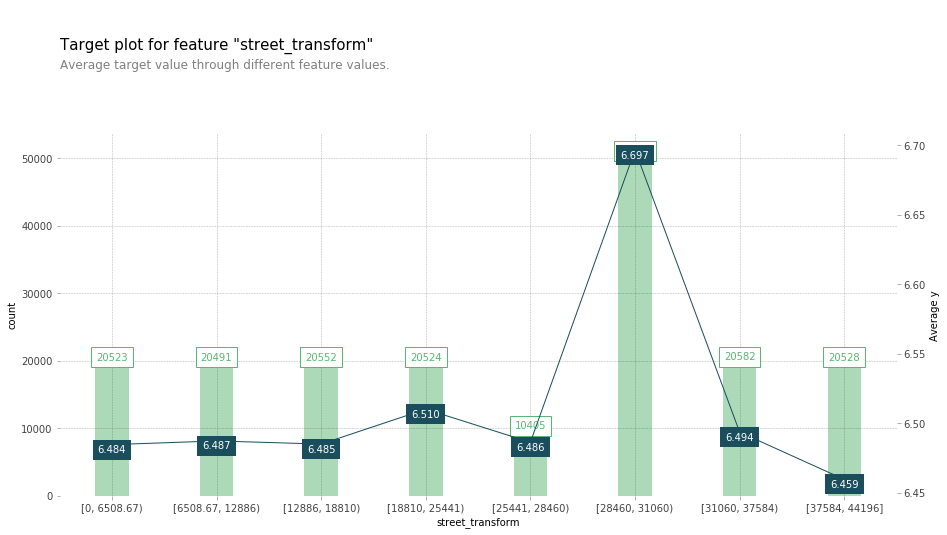

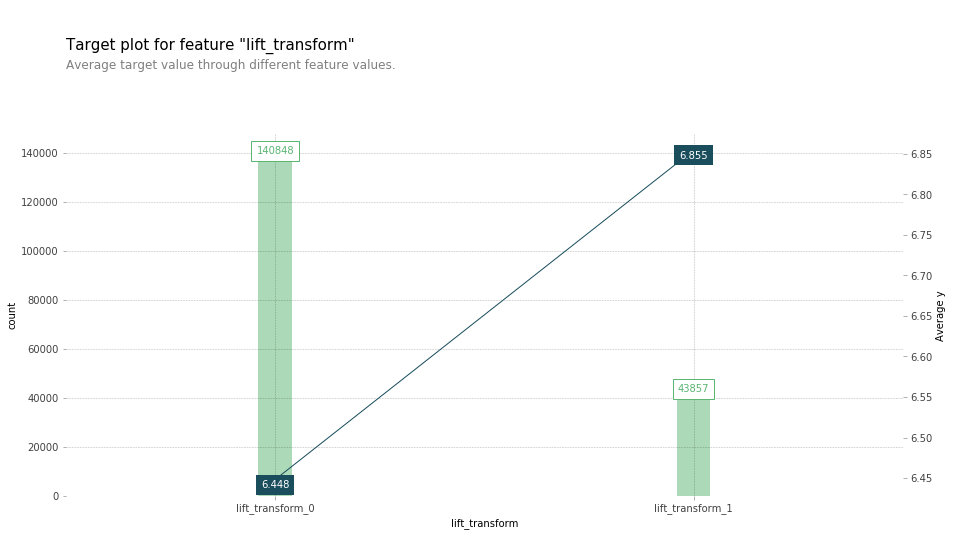

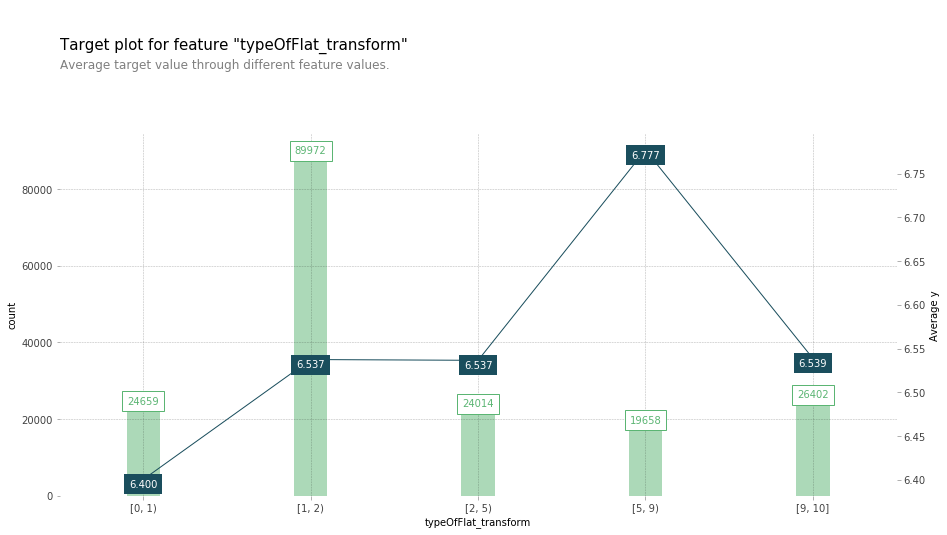

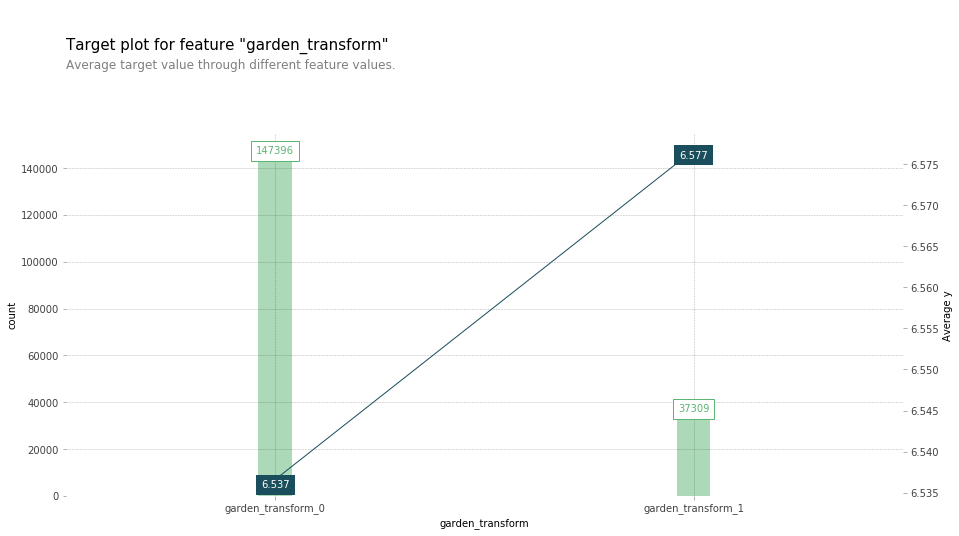

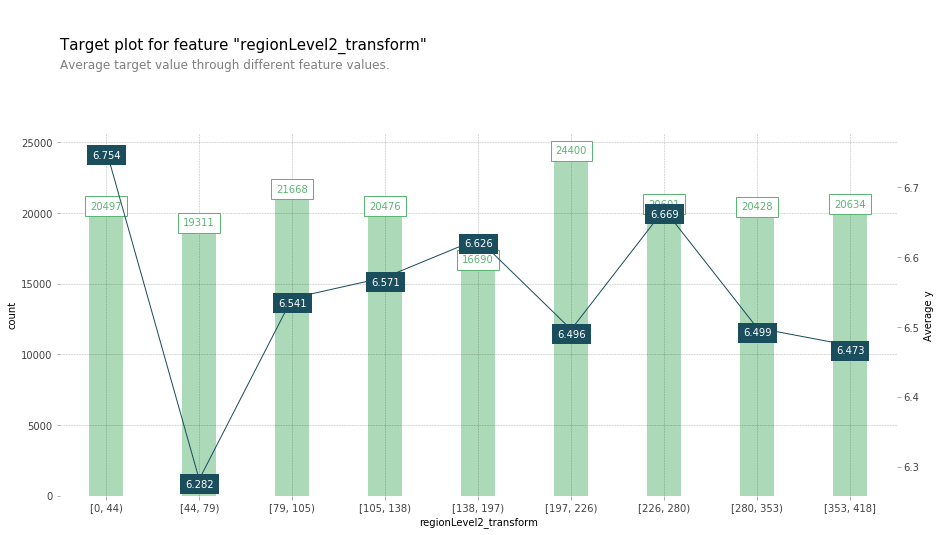

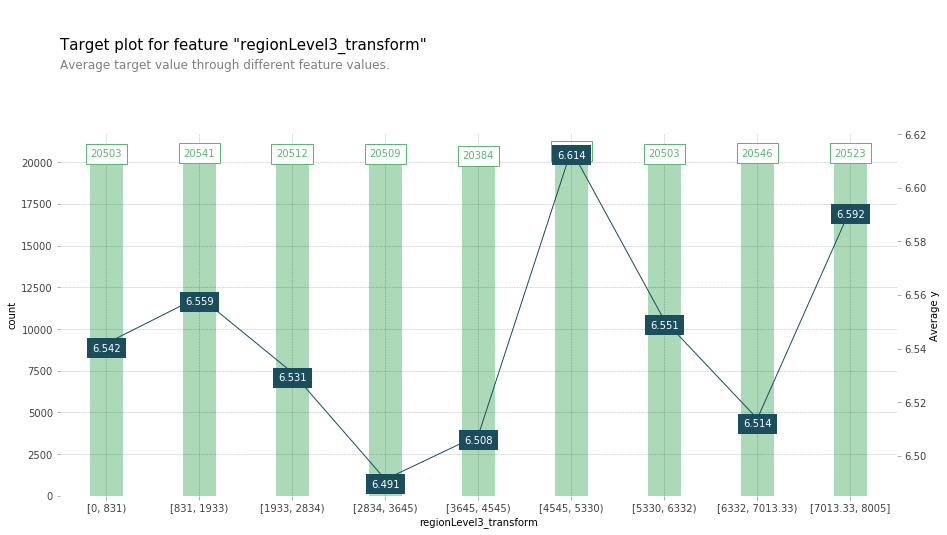

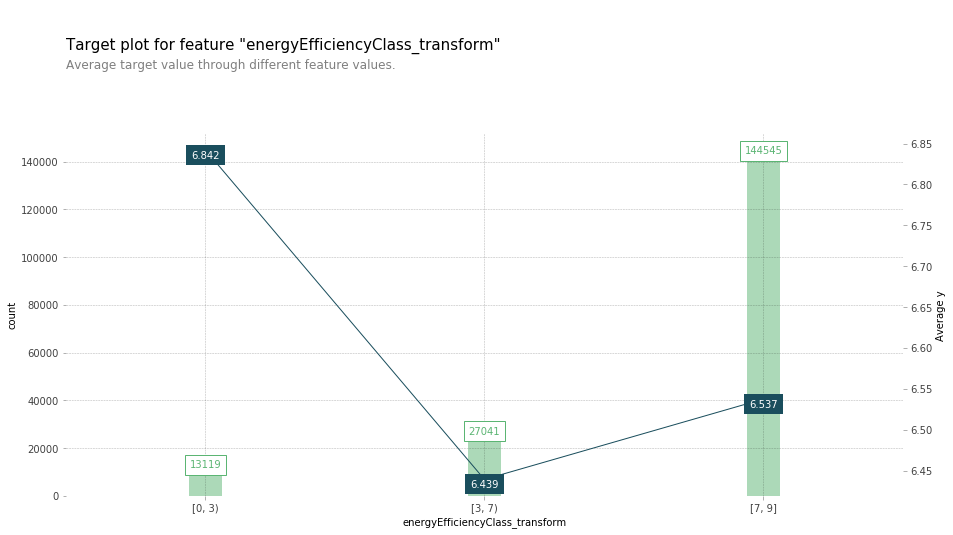

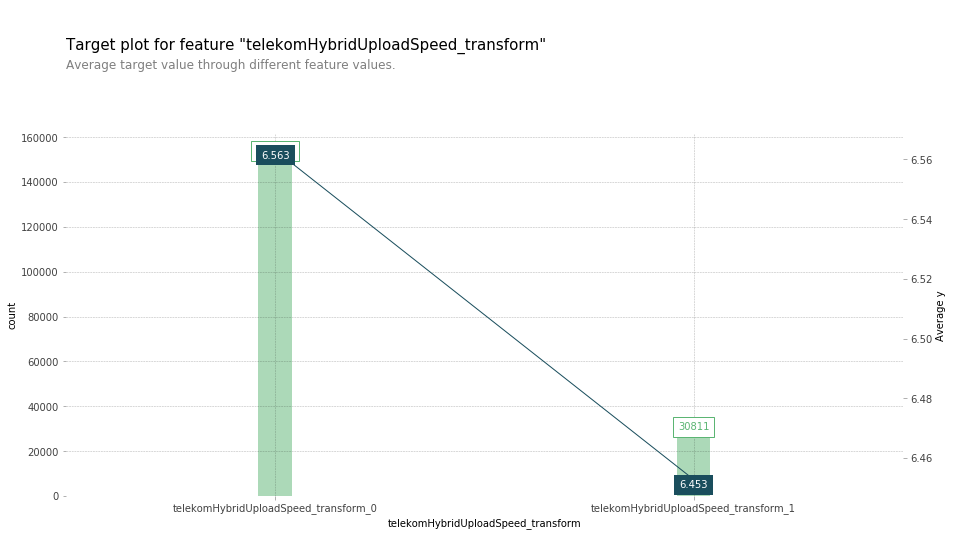

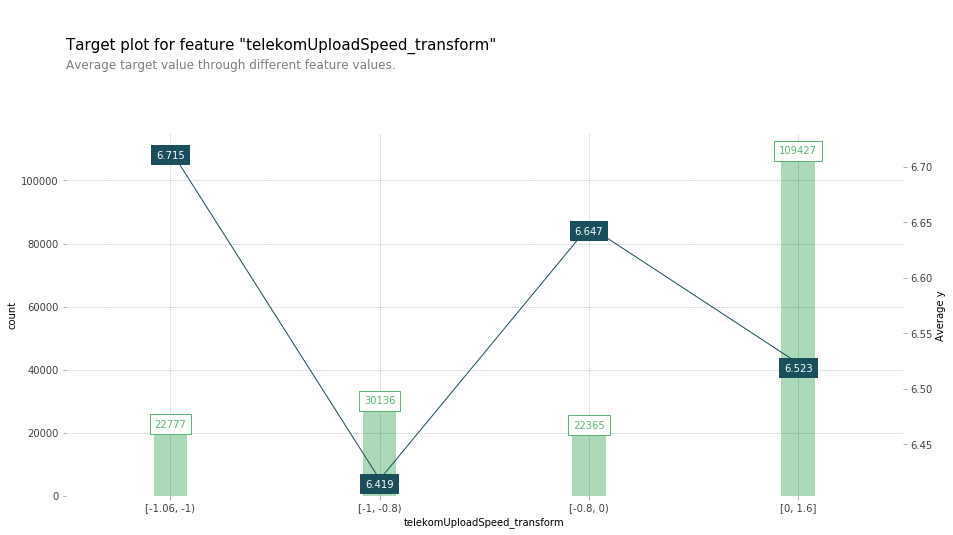

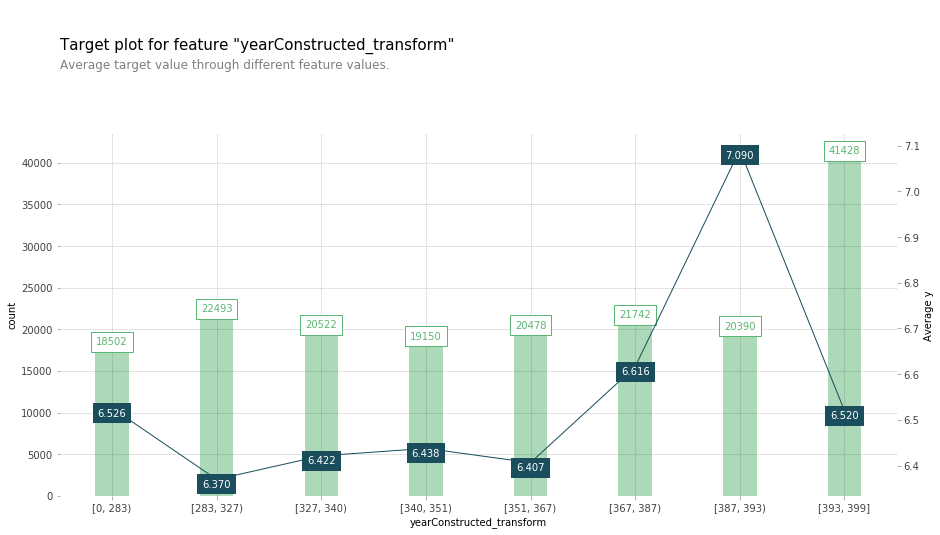

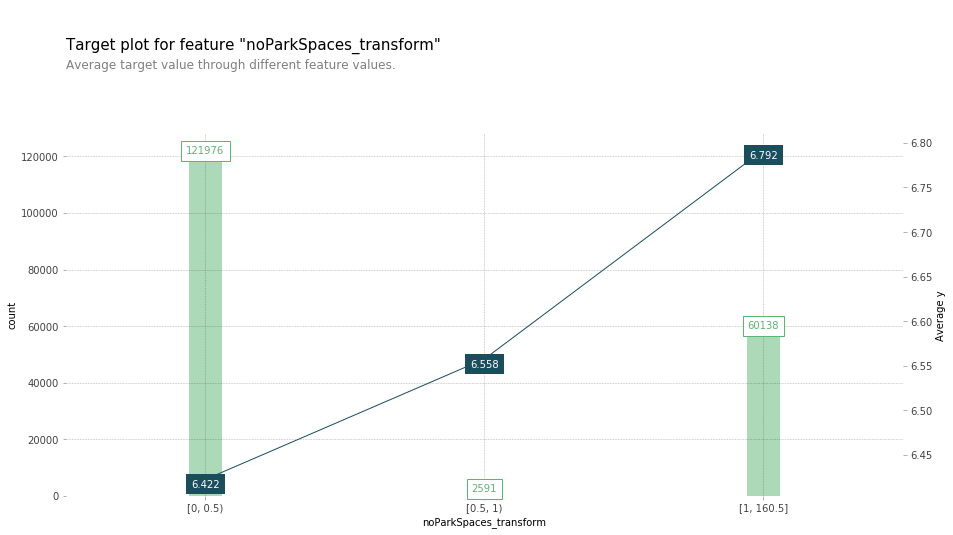

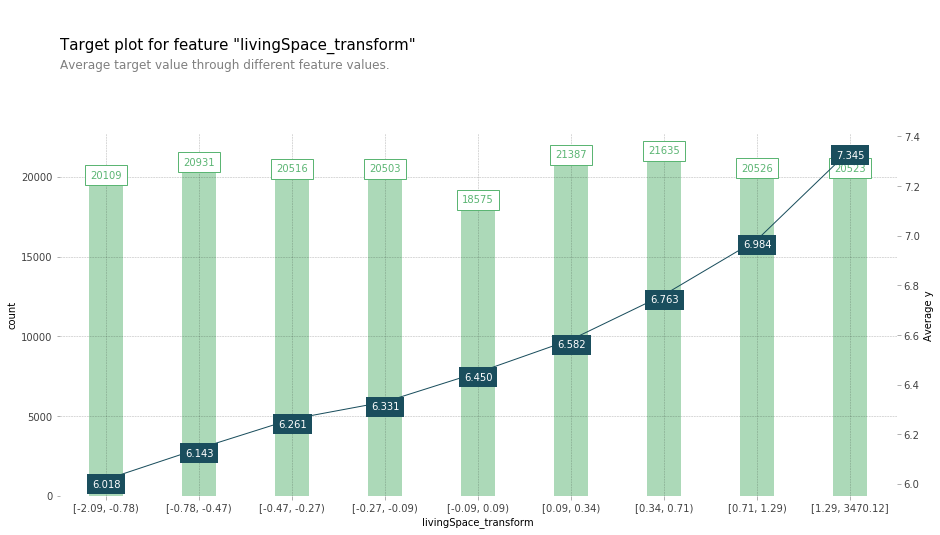

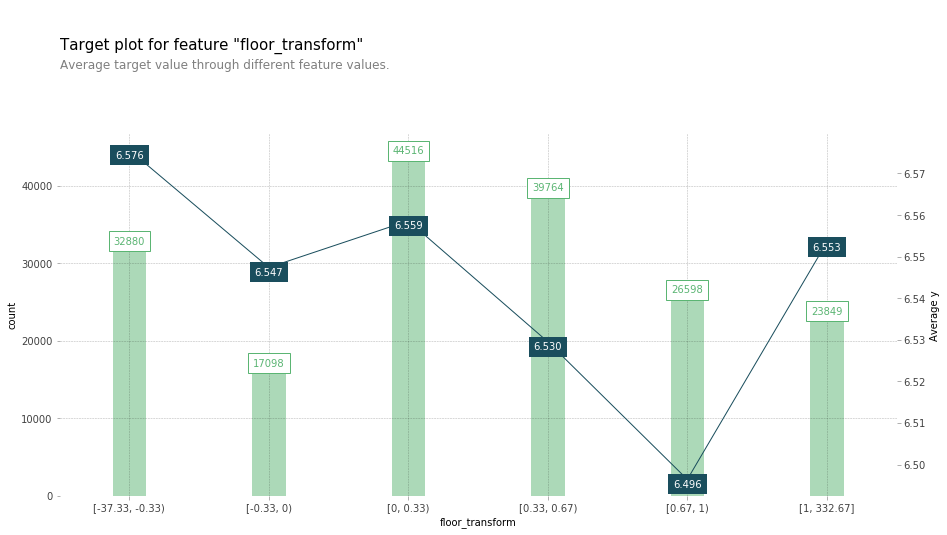

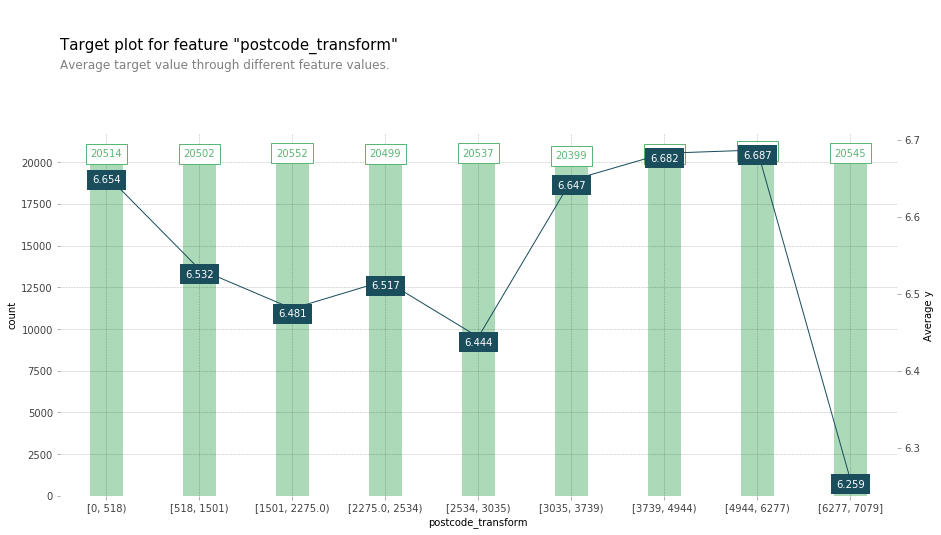

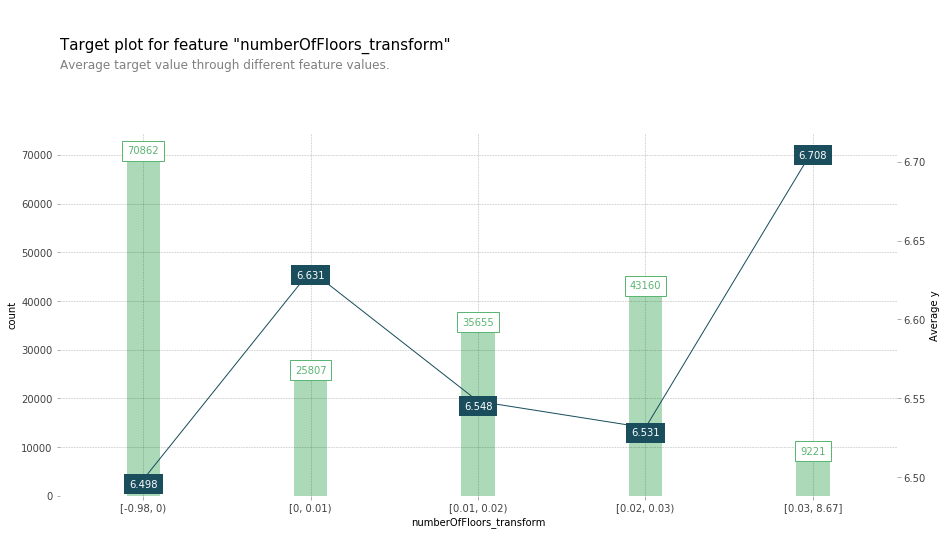

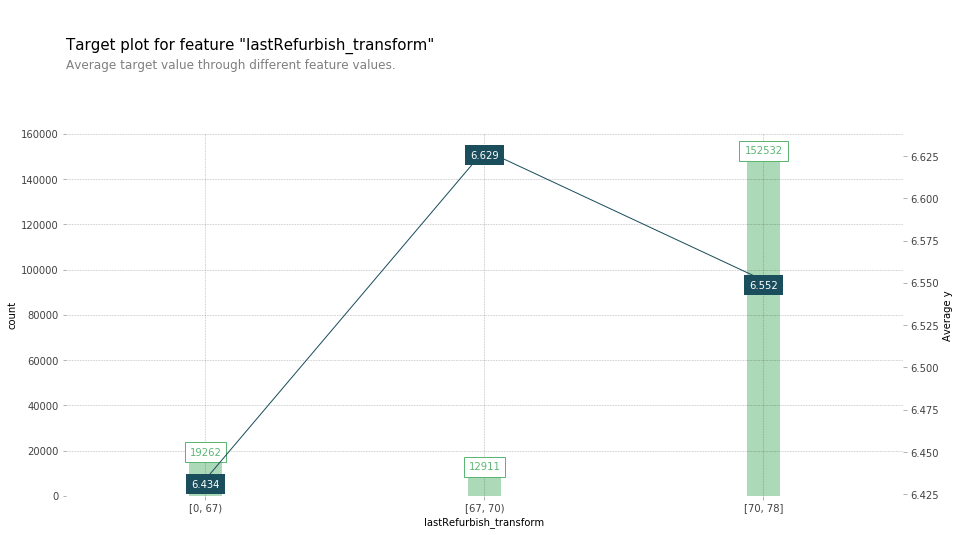

In [236]:
df_test = pd.merge(X_train, Y_train, left_index=True, right_index=True)


for feature in ['regionLevel1_transform', 'heatingType_transform', 'telekomTvOffer_transform', 'newlyConst_transform',
                'balcony_transform', 'firingTypes_transform', 'kitchen_transform', 'cellar_transform', 'houseNumber_transform',
                'condition_transform', 'interiorQuality_transform', 'petsAllowed_transform', 'street_transform', 'lift_transform',
                'typeOfFlat_transform', 'garden_transform', 'regionLevel2_transform', 'regionLevel3_transform', 
                'energyEfficiencyClass_transform',
                'telekomHybridUploadSpeed_transform','telekomUploadSpeed_transform',
                'yearConstructed_transform','noParkSpaces_transform','livingSpace_transform',
                'floor_transform','postcode_transform','numberOfFloors_transform','lastRefurbish_transform']:
    fig, axes, summary_df = info_plots.target_plot(
    df=df_test, feature=feature, feature_name=feature, target='y'
)

# Interaction between two variables
## Target distribution through feature combination

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


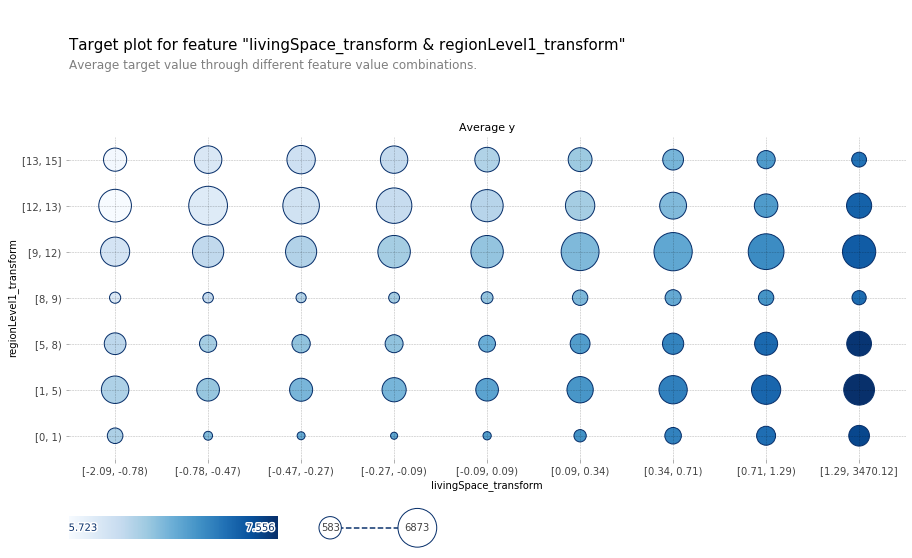

In [244]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df_test, features=['livingSpace_transform',  'regionLevel1_transform'], 
    feature_names=['livingSpace_transform',  'regionLevel1_transform'], target= 'y')


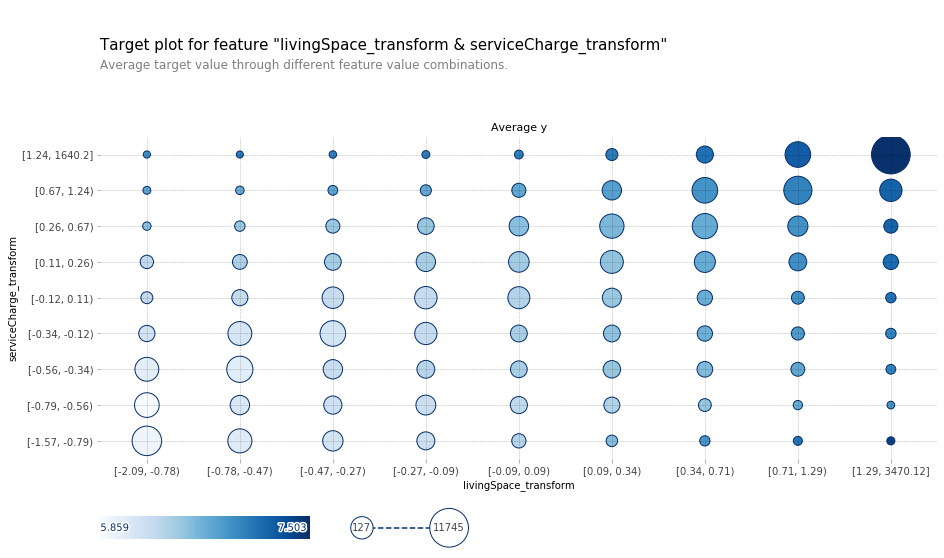

In [246]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df_test, features=['livingSpace_transform',  'serviceCharge_transform'], 
    feature_names=['livingSpace_transform',  'serviceCharge_transform'], target= 'y')


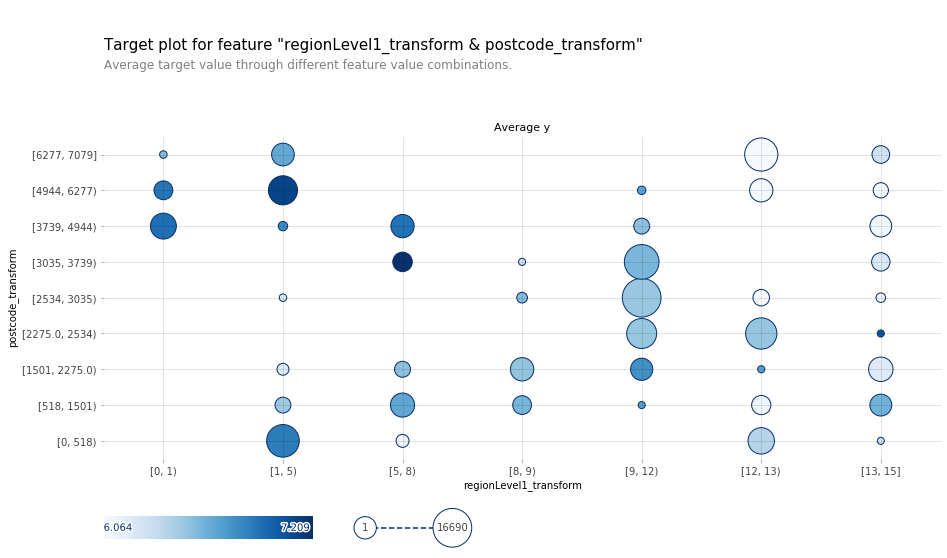

In [247]:
fig, axes, summary_df = info_plots.target_plot_interact(
    df=df_test, features=['regionLevel1_transform',  'postcode_transform'], 
    feature_names=['regionLevel1_transform',  'postcode_transform'], target= 'y')


# Feature Engineering

## Feature Transformation (Skewed Features) 

We should also take care of the skewness of the features in our dataset. We use skew() from the scipy.stats module to identify which columns are skewed.

Any skewness greater than 0.5 is actually considered slightly skewed hence we will perform log-transformation for any values greather than that.

In [248]:
def _scores(y, yp, type):
    mse = mean_squared_error(y, yp)
    print("MSE_{0}: %.2f".format(type) %mse)
    print("RMSE_{0}: %.2f".format(type) % (mse ** (1 / 2.0)))
    r2 = r2_score(y, yp)
    print('r2_{0}:%.2f'.format(type) %r2)


In [283]:
skewed = X_train.apply(lambda x: skew(x.astype(float)))
skewed = skewed[skewed >0.5]
skewed = skewed.index

X_train[skewed] = np.log1p(X_train[skewed])
X_valid[skewed] = np.log1p(X_valid[skewed])

In [289]:
X_train[skewed]

kitchen_transform  newlyConst_transform  lift_transform  \
0                0.693147              0.000000        0.000000   
1                0.000000              0.000000        0.000000   
2                0.693147              0.000000        0.000000   
3                0.000000              0.000000        0.000000   
4                0.000000              0.000000        0.000000   
...                   ...                   ...             ...   
184700           0.693147              0.693147        0.000000   
184701           0.000000              0.000000        0.000000   
184702           0.000000              0.000000        0.693147   
184703           0.000000              0.000000        0.000000   
184704           0.693147              0.000000        0.693147   

        garden_transform  heatingType_transform  firingTypes_transform  \
0               0.000000               0.693147               0.000000   
1               0.000000               0.693147               3.610918   
2               0.693147               0.693147               3.610918   
3               0.000000               0.693147               3.610918   
4               0.000000               0.693147               3.610918   
...                  ...                    ...                    ...   
184700          0.000000               2.639057               4.406719   
184701          0.693147               1.386294               0.000000   
184702          0.000000               1.386294               2.197225   
184703          0.693147               0.693147               2.197225   
184704          0.693147               0.693147               0.000000   

        petsAllowed_transform  typeOfFlat_transform  \
0                    0.000000              0.000000   
1                    0.000000              0.000000   
2                    0.693147              2.302585   
3                    0.000000              0.693147   
4                    1.098612              0.693147   
...                       ...                   ...   
184700               1.098612              0.693147   
184701               0.000000              0.000000   
184702               0.693147              0.693147   
184703               0.693147              0.693147   
184704               0.693147              0.693147   

        telekomHybridUploadSpeed_transform  serviceCharge_transform  \
0                                 0.000000                -0.119189   
1                                 0.000000                      NaN   
2                                 0.000000                -0.596816   
3                                 0.000000                -0.119189   
4                                 0.000000                 0.753111   
...                                    ...                      ...   
184700                            0.000000                 0.641262   
184701                            0.693147                -0.537393   
184702                            0.693147                -0.411099   
184703                            0.000000                -0.596816   
184704                            0.000000                 0.106483   

        noRooms_transform  heatingCosts_transform  livingSpace_transform  \
0                    -inf                0.000000              -1.329205   
1                     NaN                0.000000                    NaN   
2                    -inf                0.000000              -0.826679   
3                0.000000                0.000000              -0.098440   
4                0.000000                0.000000               0.594707   
...                   ...                     ...                    ...   
184700           0.000000                0.000000               0.521395   
184701           0.693147                0.856132               0.135405   
184702                NaN                0.723731              -1.163151   
184703           0.000000               

In [313]:
best_model = XGBRegressor(n_estimators=100, learning_rate=0.2)

In [ ]:
livingSpace_transform, noRooms_transform, serviceCharge_transform

In [261]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184705 entries, 0 to 184704
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   kitchen_transform                   184705 non-null  float64
 1   newlyConst_transform                184705 non-null  float64
 2   balcony_transform                   184705 non-null  int64  
 3   cellar_transform                    184705 non-null  int64  
 4   lift_transform                      184705 non-null  float64
 5   garden_transform                    184705 non-null  float64
 6   regionLevel1_transform              184705 non-null  int64  
 7   heatingType_transform               184705 non-null  float64
 8   telekomTvOffer_transform            184705 non-null  int64  
 9   firingTypes_transform               184705 non-null  float64
 10  houseNumber_transform               184705 non-null  int64  
 11  condition_transform       

In [299]:
best_model.fit(X_train, Y_train,
              eval_set=[(X_train, Y_train), (X_valid, Y_valid)],
              eval_metric='rmsle')

[0]	validation_0-rmsle:1.02344	validation_1-rmsle:1.02309
[1]	validation_0-rmsle:0.71859	validation_1-rmsle:0.71833
[2]	validation_0-rmsle:0.52797	validation_1-rmsle:0.52752
[3]	validation_0-rmsle:0.39808	validation_1-rmsle:0.39767
[4]	validation_0-rmsle:0.30523	validation_1-rmsle:0.30499
[5]	validation_0-rmsle:0.23682	validation_1-rmsle:0.23662
[6]	validation_0-rmsle:0.18545	validation_1-rmsle:0.18535
[7]	validation_0-rmsle:0.14635	validation_1-rmsle:0.14705
[8]	validation_0-rmsle:0.11638	validation_1-rmsle:0.11747
[9]	validation_0-rmsle:0.09328	validation_1-rmsle:0.09471
[10]	validation_0-rmsle:0.07538	validation_1-rmsle:0.07785
[11]	validation_0-rmsle:0.06168	validation_1-rmsle:0.06438
[12]	validation_0-rmsle:0.05121	validation_1-rmsle:0.05435
[13]	validation_0-rmsle:0.04329	validation_1-rmsle:0.04650
[14]	validation_0-rmsle:0.03742	validation_1-rmsle:0.04121
[15]	validation_0-rmsle:0.03311	validation_1-rmsle:0.03720
[16]	validation_0-rmsle:0.02997	validation_1-rmsle:0.03449
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=30, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [300]:
preds_val = best_model.predict(X_valid)
preds_train = best_model.predict(X_train)

t1 = _scores(Y_train, preds_train, 'train')
print('')
t2 = _scores(Y_valid, preds_val, 'valid')

MSE_train: 0.03
RMSE_train: 0.16
r2_train:0.91

MSE_valid: 0.05
RMSE_valid: 0.22
r2_valid:0.83


## Correlation 

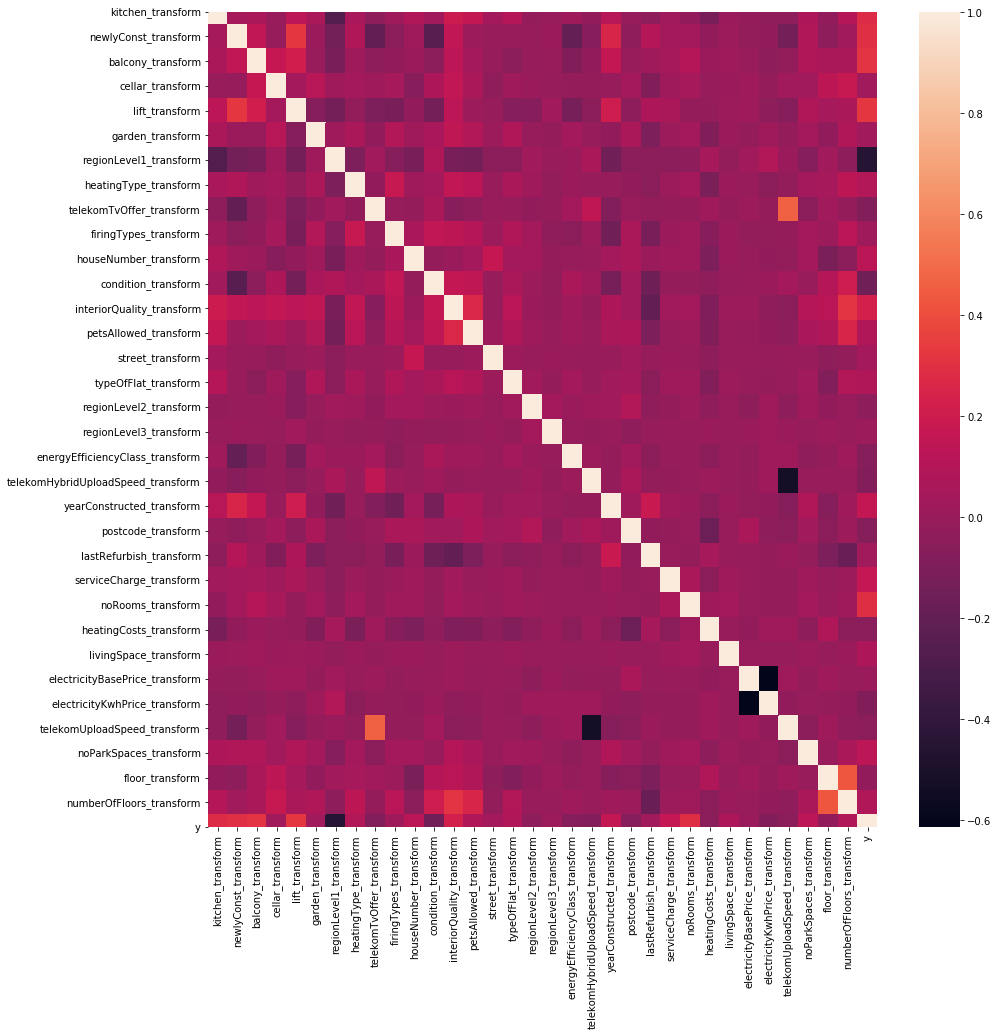

In [238]:
plt.figure(figsize=(15, 15))
sns.heatmap(df_test.corr())

kitchen_transform  newlyConst_transform  balcony_transform  \
y           0.276078              0.294634           0.317348   

   cellar_transform  lift_transform  garden_transform  regionLevel1_transform  \
y          0.033031         0.32361          0.030121               -0.452854   

   heatingType_transform  telekomTvOffer_transform  firingTypes_transform  \
y               0.095963                 -0.081883               0.021338   

   ...  noRooms_transform  heatingCosts_transform  livingSpace_transform  \
y  ...           0.290905               -0.058304               0.076579   

   electricityBasePrice_transform  electricityKwhPrice_transform  \
y                        0.005963                      -0.089964   

   telekomUploadSpeed_transform  noParkSpaces_transform  floor_transform  \
y                     -0.046504                0.132763        -0.027235   

   numberOfFloors_transform    y  
y                  0.082326  1.0  

[1 rows x 34 columns]

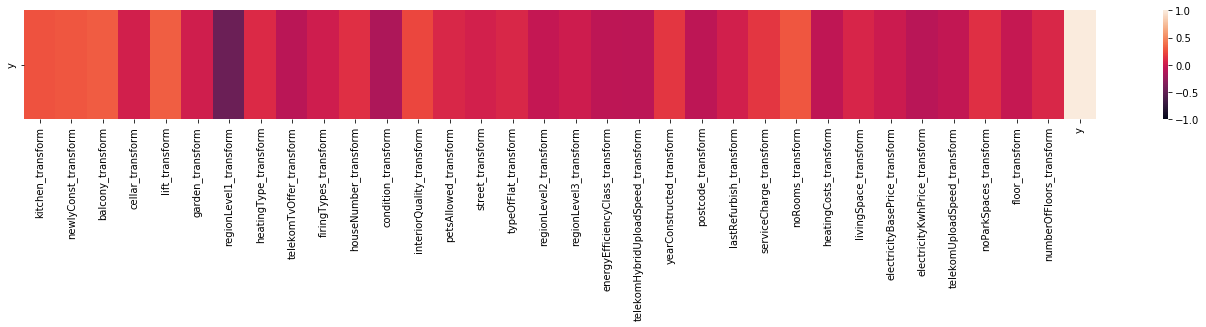

In [240]:
plt.figure(figsize=(24, 2))
corr = df_test.corr().iloc[[-1]] # change to price! 
display(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.index, vmax=1, vmin=-1) 

### Feature Selection

In [301]:
full = pd.merge(left = X_train, right = Y_train , left_index= True, right_index = True)
mi = mutual_info_regression(X = full.drop('y', axis = 1), y = full['y'])
mi_df = pd.DataFrame(list(zip(full.columns,mi)), columns =['Feature','Mutual Info'])
mi_df = mi_df.sort_values('Mutual Info',ascending=False)
low_mi_df = mi_df[abs(mi_df['Mutual Info']) <= 0.017]
filter_feature = sorted(list(low_mi_df['Feature']))
print("Number of low correlated features dropped: " + str(len(filter_feature)))

Number of low correlated features dropped: 4


In [302]:
X_train_, X_valid_ = X_train.drop(filter_feature,axis=1), X_valid.drop(filter_feature,axis=1)

In [306]:
best_model.fit(X_train_, Y_train,
              eval_set=[(X_train_, Y_train), (X_valid_, Y_valid)],
              eval_metric='rmsle')

[0]	validation_0-rmsle:1.02344	validation_1-rmsle:1.02309
[1]	validation_0-rmsle:0.71859	validation_1-rmsle:0.71833
[2]	validation_0-rmsle:0.52797	validation_1-rmsle:0.52752
[3]	validation_0-rmsle:0.39808	validation_1-rmsle:0.39767
[4]	validation_0-rmsle:0.30523	validation_1-rmsle:0.30499
[5]	validation_0-rmsle:0.23682	validation_1-rmsle:0.23662
[6]	validation_0-rmsle:0.18545	validation_1-rmsle:0.18535
[7]	validation_0-rmsle:0.14635	validation_1-rmsle:0.14705
[8]	validation_0-rmsle:0.11638	validation_1-rmsle:0.11747
[9]	validation_0-rmsle:0.09328	validation_1-rmsle:0.09471
[10]	validation_0-rmsle:0.07538	validation_1-rmsle:0.07785
[11]	validation_0-rmsle:0.06168	validation_1-rmsle:0.06438
[12]	validation_0-rmsle:0.05121	validation_1-rmsle:0.05435
[13]	validation_0-rmsle:0.04329	validation_1-rmsle:0.04650
[14]	validation_0-rmsle:0.03742	validation_1-rmsle:0.04121
[15]	validation_0-rmsle:0.03311	validation_1-rmsle:0.03720
[16]	validation_0-rmsle:0.02997	validation_1-rmsle:0.03449
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=50, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [307]:
preds_val = best_model.predict(X_valid_)
preds_train = best_model.predict(X_train_)

t1 = _scores(Y_train, preds_train, 'train')
print('')
t2 = _scores(Y_valid, preds_val, 'valid')

MSE_train: 0.02
RMSE_train: 0.15
r2_train:0.92

MSE_valid: 0.05
RMSE_valid: 0.22
r2_valid:0.82


### Polynomial and Interaction Features

In [308]:
top_mi_list = list(mi_df.head(10)['Feature'])
top_mi_subset = X_train[top_mi_list]
index_copy = top_mi_subset.index
poly = PolynomialFeatures(2, interaction_only=True)
poly_features = pd.DataFrame(poly.fit_transform(top_mi_subset), columns=poly.get_feature_names(top_mi_list))
poly_features = poly_features.iloc[:,len(top_mi_list) + 1:]
poly_features.set_index(index_copy, inplace = True)
poly_and_price = pd.concat([Y_train, poly_features],axis=1).dropna()
top_20_poly = abs(poly_and_price.corr()['y']).sort_values(ascending=False)[1:21]
_X_train = pd.concat([X_train,poly_features[top_20_poly.index]],axis=1)

In [309]:
top_mi_subset = X_valid[top_mi_list]
index_copy = top_mi_subset.index
poly_features = pd.DataFrame(poly.transform(top_mi_subset),columns=poly.get_feature_names(top_mi_list))
poly_features = poly_features.iloc[:,len(top_mi_list) + 1:]
poly_features.set_index(index_copy, inplace = True)

_X_valid = pd.concat([X_valid,poly_features[top_20_poly.index]],axis=1)

In [314]:
best_model.fit(_X_train, Y_train,
              eval_set=[(_X_train, Y_train), (_X_valid, Y_valid)],
              eval_metric='rmsle')

[0]	validation_0-rmsle:1.02344	validation_1-rmsle:1.02416
[1]	validation_0-rmsle:0.71859	validation_1-rmsle:0.71884
[2]	validation_0-rmsle:0.52795	validation_1-rmsle:0.52870
[3]	validation_0-rmsle:0.39805	validation_1-rmsle:0.39882
[4]	validation_0-rmsle:0.30520	validation_1-rmsle:0.30603
[5]	validation_0-rmsle:0.23681	validation_1-rmsle:0.23810
[6]	validation_0-rmsle:0.18543	validation_1-rmsle:0.18698
[7]	validation_0-rmsle:0.14632	validation_1-rmsle:0.14795
[8]	validation_0-rmsle:0.11634	validation_1-rmsle:0.11832
[9]	validation_0-rmsle:0.09320	validation_1-rmsle:0.09568
[10]	validation_0-rmsle:0.07540	validation_1-rmsle:0.07816
[11]	validation_0-rmsle:0.06164	validation_1-rmsle:0.06510
[12]	validation_0-rmsle:0.05115	validation_1-rmsle:0.05466
[13]	validation_0-rmsle:0.04321	validation_1-rmsle:0.04705
[14]	validation_0-rmsle:0.03728	validation_1-rmsle:0.04132
[15]	validation_0-rmsle:0.03291	validation_1-rmsle:0.03748
[16]	validation_0-rmsle:0.02973	validation_1-rmsle:0.03422
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [315]:
preds_val = best_model.predict(_X_valid)
preds_train = best_model.predict(_X_train)

t1 = _scores(Y_train, preds_train, 'train')
print('')
t2 = _scores(Y_valid, preds_val, 'valid')

MSE_train: 0.02
RMSE_train: 0.13
r2_train:0.94

MSE_valid: 0.05
RMSE_valid: 0.21
r2_valid:0.84


### Outlier Identification

In [334]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(random_state=0)
df_without_outlier = pd.Series(iso_forest.fit_predict(X_train), index = full.index)
df = X_train.loc[df_without_outlier.index[df_without_outlier == 1],:]

About 47.26% of variation in the Price can be explained by the model.


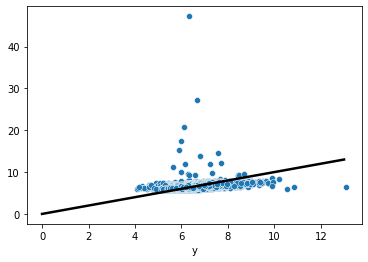

In [347]:
full = pd.merge(left = X_train, right = Y_train , left_index= True, right_index = True)
linear = LinearRegression()
Y = full['y']
linear.fit(full.drop(['y'],axis=1), Y)
Y_hat = linear.predict(full.drop(['y'],axis=1))
residuals = Y - Y_hat
y_vs_yhat_df = pd.DataFrame(zip(Y.values,Y_hat,residuals),columns=['y','yhat','residuals'],index=full.index)

r2 = r2_score(Y, Y_hat)
print("About " + str(round(r2 * 100,2)) + "% of variation in the Price can be explained by the model.")

sns.scatterplot(Y, Y_hat)
sns.lineplot(np.linspace(0,13),np.linspace(0,13), color='black', linewidth=2.5)
plt.show()

In [359]:
standard_residuals = (residuals - residuals.mean()) / residuals.std()
outliers = full[abs(standard_residuals) > 3]
y_vs_yhat_df.loc[y_vs_yhat_df.index.isin(outliers.index),'Outlier'] = 1
y_vs_yhat_df.loc[y_vs_yhat_df['Outlier'] != 1 ,'Outlier'] = 0

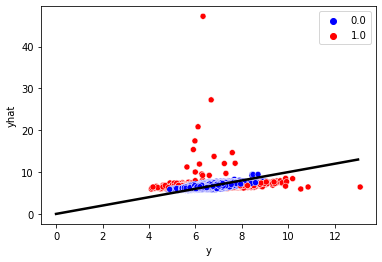

In [360]:
sns.scatterplot(data = y_vs_yhat_df, x='y', y='yhat',hue ='Outlier', palette = ['blue','red'])
sns.lineplot(np.linspace(0,13),np.linspace(0,13), color='black', linewidth=2.5)
plt.show()

In [361]:
X_train__ = X_train.loc[y_vs_yhat_df[y_vs_yhat_df['Outlier'] == 0].index,:]
full_ = pd.merge(left = X_train__, right = Y_train , left_index= True, right_index = True)
X_train__, Y_train__ = full_.drop(['y'],axis=1),full_[['y']] 

In [362]:
best_model.fit(X_train__, Y_train__,
              eval_set=[(X_train__, Y_train__), (X_valid, Y_valid)],
              eval_metric='rmsle')

[0]	validation_0-rmsle:1.02310	validation_1-rmsle:1.02317
[1]	validation_0-rmsle:0.71839	validation_1-rmsle:0.71845
[2]	validation_0-rmsle:0.52781	validation_1-rmsle:0.52816
[3]	validation_0-rmsle:0.39796	validation_1-rmsle:0.39812
[4]	validation_0-rmsle:0.30511	validation_1-rmsle:0.30529
[5]	validation_0-rmsle:0.23671	validation_1-rmsle:0.23725
[6]	validation_0-rmsle:0.18533	validation_1-rmsle:0.18634
[7]	validation_0-rmsle:0.14621	validation_1-rmsle:0.14731
[8]	validation_0-rmsle:0.11620	validation_1-rmsle:0.11754
[9]	validation_0-rmsle:0.09303	validation_1-rmsle:0.09515
[10]	validation_0-rmsle:0.07516	validation_1-rmsle:0.07778
[11]	validation_0-rmsle:0.06141	validation_1-rmsle:0.06435
[12]	validation_0-rmsle:0.05087	validation_1-rmsle:0.05392
[13]	validation_0-rmsle:0.04287	validation_1-rmsle:0.04643
[14]	validation_0-rmsle:0.03686	validation_1-rmsle:0.04031
[15]	validation_0-rmsle:0.03242	validation_1-rmsle:0.03649
[16]	validation_0-rmsle:0.02916	validation_1-rmsle:0.03387
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [363]:
preds_val = best_model.predict(X_valid)
preds_train = best_model.predict(X_train__)

t1 = _scores(Y_train__, preds_train, 'train')
print('')
t2 = _scores(Y_valid, preds_val, 'valid')

MSE_train: 0.02
RMSE_train: 0.13
r2_train:0.94

MSE_valid: 0.05
RMSE_valid: 0.22
r2_valid:0.83


## Number of labels: cardinality
### Let's evaluate how many different categories are present in each of the variables.

In [382]:
test_list = ['regionLevel1_transform',
 'heatingType_transform',
 'telekomTvOffer_transform',
 'firingTypes_transform',
 'houseNumber_transform',
 'condition_transform',
 'interiorQuality_transform',
 'petsAllowed_transform',
 'street_transform',
 'typeOfFlat_transform',
 'regionLevel2_transform',
 'regionLevel3_transform',
 'energyEfficiencyClass_transform',
 'telekomHybridUploadSpeed_transform',
 'yearConstructed_transform',
 'postcode_transform',
 'lastRefurbish_transform']

df[test_list].nunique().sort_values(ascending=False)

street_transform                      35735
regionLevel3_transform                 6690
postcode_transform                     6018
houseNumber_transform                  3597
regionLevel2_transform                  419
yearConstructed_transform               318
firingTypes_transform                    84
lastRefurbish_transform                  66
regionLevel1_transform                   16
heatingType_transform                    14
typeOfFlat_transform                     11
condition_transform                      11
energyEfficiencyClass_transform          10
interiorQuality_transform                 5
petsAllowed_transform                     4
telekomTvOffer_transform                  4
telekomHybridUploadSpeed_transform        2
dtype: int64

In [385]:
df[test_list].nunique().sort_values(ascending=False) / len(df)

street_transform                      0.258432
regionLevel3_transform                0.048381
postcode_transform                    0.043522
houseNumber_transform                 0.026013
regionLevel2_transform                0.003030
yearConstructed_transform             0.002300
firingTypes_transform                 0.000607
lastRefurbish_transform               0.000477
regionLevel1_transform                0.000116
heatingType_transform                 0.000101
typeOfFlat_transform                  0.000080
condition_transform                   0.000080
energyEfficiencyClass_transform       0.000072
interiorQuality_transform             0.000036
petsAllowed_transform                 0.000029
telekomTvOffer_transform              0.000029
telekomHybridUploadSpeed_transform    0.000014
dtype: float64

In [386]:
X_train_2, X_valid_2 = X_train.drop('street_transform',axis=1), X_valid.drop('street_transform',axis=1)

best_model.fit(X_train_2, Y_train,
              eval_set=[(X_train_2, Y_train), (X_valid_2, Y_valid)],
              eval_metric='rmsle')

[0]	validation_0-rmsle:1.02344	validation_1-rmsle:1.02309
[1]	validation_0-rmsle:0.71859	validation_1-rmsle:0.71833
[2]	validation_0-rmsle:0.52797	validation_1-rmsle:0.52752
[3]	validation_0-rmsle:0.39808	validation_1-rmsle:0.39767
[4]	validation_0-rmsle:0.30523	validation_1-rmsle:0.30499
[5]	validation_0-rmsle:0.23682	validation_1-rmsle:0.23662
[6]	validation_0-rmsle:0.18545	validation_1-rmsle:0.18535
[7]	validation_0-rmsle:0.14635	validation_1-rmsle:0.14705
[8]	validation_0-rmsle:0.11638	validation_1-rmsle:0.11747
[9]	validation_0-rmsle:0.09328	validation_1-rmsle:0.09471
[10]	validation_0-rmsle:0.07538	validation_1-rmsle:0.07785
[11]	validation_0-rmsle:0.06168	validation_1-rmsle:0.06438
[12]	validation_0-rmsle:0.05121	validation_1-rmsle:0.05435
[13]	validation_0-rmsle:0.04329	validation_1-rmsle:0.04650
[14]	validation_0-rmsle:0.03742	validation_1-rmsle:0.04121
[15]	validation_0-rmsle:0.03311	validation_1-rmsle:0.03720
[16]	validation_0-rmsle:0.02997	validation_1-rmsle:0.03449
[17]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.2, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [387]:
preds_val = best_model.predict(X_valid_2)
preds_train = best_model.predict(X_train_2)

t1 = _scores(Y_train, preds_train, 'train')
print('')
t2 = _scores(Y_valid, preds_val, 'valid')

MSE_train: 0.02
RMSE_train: 0.14
r2_train:0.94

MSE_valid: 0.05
RMSE_valid: 0.22
r2_valid:0.82


In [ ]:
#Conclusion only Outlier identification and Polynomial or Interaction Features effect to R2 and MSE value

## MODELING 

In [396]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [397]:
def rmse(a, b):
    return mean_squared_error(a, b, squared=False)

In [395]:
def train_and_evaluate(X_train, train_targets, X_val, val_targets, **params):
    model = XGBRegressor(random_state=42, n_jobs=-1, **params)
    model.fit(X_train, train_targets)
    train_rmse = rmse(model.predict(X_train), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    return model, train_rmse, val_rmse

In [405]:
kfold = KFold(n_splits=3)

In [406]:
models = []

for train_idxs, val_idxs in kfold.split(X):
    X_tr, train_targets = X_train.iloc[train_idxs], Y_train.iloc[train_idxs]
    X_val, val_targets = X_train.iloc[val_idxs], Y_train.iloc[val_idxs]
    model, train_rmse, val_rmse = train_and_evaluate(X_tr, 
                                                     train_targets, 
                                                     X_val, 
                                                     val_targets, 
                                                     max_depth=4, 
                                                     n_estimators=20)
    models.append(model)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

Train RMSE: 0.09872096248876532, Validation RMSE: 0.3324040349433206
Train RMSE: 0.09574895955400298, Validation RMSE: 0.30729717379072063
Train RMSE: 0.11733967546051914, Validation RMSE: 0.03496138797745285


In [407]:
def test_params_kfold(n_splits, **params):
    train_rmses, val_rmses, models = [], [], []
    kfold = KFold(n_splits)
    for train_idxs, val_idxs in kfold.split(X):
        X_train, train_targets = X.iloc[train_idxs], targets.iloc[train_idxs]
        X_val, val_targets = X.iloc[val_idxs], targets.iloc[val_idxs]
        model, train_rmse, val_rmse = train_and_evaluate(X_train, train_targets, X_val, val_targets, **params)
        models.append(model)
        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
    print('Train RMSE: {}, Validation RMSE: {}'.format(np.mean(train_rmses), np.mean(val_rmses)))
    return models

In [408]:
X_tra, X_val, train_targets, val_targets = train_test_split(X_train, Y_train, test_size=0.1)

In [413]:
def test_params(**params):
    model = XGBRegressor(n_jobs=-1, random_state=42, **params)
    model.fit(X_tra, train_targets)
    train_rmse = rmse(model.predict(X_tra), train_targets)
    val_rmse = rmse(model.predict(X_val), val_targets)
    print('Train RMSE: {}, Validation RMSE: {}'.format(train_rmse, val_rmse))

In [414]:
test_params(n_estimators=10)

Train RMSE: 0.25521158312590875, Validation RMSE: 0.25585165137200755


In [415]:
test_params(n_estimators=30)

Train RMSE: 0.15479412593444852, Validation RMSE: 0.15941721390171454


In [416]:
test_params(n_estimators=60)

Train RMSE: 0.14000944617428507, Validation RMSE: 0.1489297119167488


In [425]:
test_params(n_estimators=80)

Train RMSE: 0.13490976645335928, Validation RMSE: 0.14536898294343878


In [417]:
test_params(max_depth=2)

Train RMSE: 0.17760721849935068, Validation RMSE: 0.17777650270922715


In [418]:
test_params(max_depth=5)

Train RMSE: 0.13991536544995842, Validation RMSE: 0.14536399477369094


In [419]:
test_params(max_depth=10)

Train RMSE: 0.08038819407907499, Validation RMSE: 0.13613582565451712


In [420]:
test_params(n_estimators=50, learning_rate=0.01)

Train RMSE: 3.677641182239151, Validation RMSE: 3.6720269938220556


In [421]:
test_params(n_estimators=50, learning_rate=0.1)

Train RMSE: 0.17054915552565877, Validation RMSE: 0.17310045976859484


In [422]:
test_params(n_estimators=50, learning_rate=0.3)

Train RMSE: 0.1441666310134096, Validation RMSE: 0.15184596934488442


In [423]:
test_params(n_estimators=50, learning_rate=0.9)

Train RMSE: 0.14064337263244778, Validation RMSE: 0.15985150362451275


In [424]:
test_params(booster='gblinear')

Train RMSE: 0.4153013797241826, Validation RMSE: 0.4623374707442678


In [426]:
test_params()

Train RMSE: 0.12987017972745768, Validation RMSE: 0.14195082629360126


In [ ]:
### Try Stacked Ensemble Models

In [430]:
from sklearn.svm import SVR
import catboost as cb
from mlxtend.regressor import StackingCVRegressor
import time

In [431]:
ridgemodel = Ridge(alpha=26)

xgbmodel = XGBRegressor(alpha= 3, colsample_bytree=0.5, reg_lambda=3, learning_rate= 0.2,\
           max_depth=10, n_estimators=200, subsample=0.65)

svrmodel = SVR(C=8, epsilon=0.00005, gamma=0.0008)

hubermodel = HuberRegressor(alpha=30,epsilon=3,fit_intercept=True,max_iter=2000)

cbmodel = cb.CatBoostRegressor(loss_function='RMSE',colsample_bylevel=0.3, depth=2, \
          l2_leaf_reg=20, learning_rate=0.005, n_estimators=15000, subsample=0.3,verbose=False)

stackmodel = StackingCVRegressor(regressors=(ridgemodel, xgbmodel, svrmodel, hubermodel, cbmodel),
             meta_regressor=cbmodel, use_features_in_secondary=True)

In [432]:
start = time.time()
print("Recording Modelling Time")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    i.fit(X_train,Y_train)
    if i == stackmodel:
        i.fit(np.array(X_train), np.array(Y_train))
end = time.time()
print("Time Elapsed: " + str(round((end - start)/60,0)) +"minutes.")

Recording Modelling Time


KeyboardInterrupt: 

In [ ]:
print("-----------------------------")
print("Overview of model performance")
print("-----------------------------")
for i in [ridgemodel,hubermodel,cbmodel,svrmodel,xgbmodel,stackmodel]:
    print("\n")
    print(i)
    print("RMSLE of Development train set: ")
    print(mean_squared_error(Y_train,i.predict(X_train), squared=False))
    print("RMSLE of Development test set: ")
    print(mean_squared_error(Y_valid,i.predict(X_valid), squared=False))
    print("\n")
print("-----------------------------")
print("RMSLE of Development train set using ensemble model: ")
#fit = (svrmodel.predict(X_train) + xgbmodel.predict(X_train) +  stackmodel.predict(X_train) + ridgemodel.predict(X_train) + hubermodel.predict(X_train) + cbmodel.predict(X_train)) / 6
fit = t = (svrmodel.predict(X_train) + xgbmodel.predict(X_train) + stackmodel.predict(X_train) + hubermodel.predict(X_train) + cbmodel.predict(X_train))/5
print(mean_squared_error(Y_train,fit, squared=False))
print("-----------------------------")